In [5]:
import sys
sys.path.append('/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/')

In [6]:
import warnings
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

import scipy.stats as stats
from collections import deque
from simulator.static_smoke import StaticSmoke, SmokeBlobParams
from simulator.dynamic_smoke import DynamicSmoke, DynamicSmokeParams, DownwardsSensorParams

from learning.base_model import BaseModel
from src.utils import *
from tqdm import tqdm
from dataclasses import dataclass

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

from envs.replay_buffer import GenericReplayBuffer
from envs.smoke_env_dyn import *

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal


import math

In [413]:

@dataclass
class ObsVAESSM:
    xs: torch.Tensor
    ys: torch.Tensor
    values: torch.Tensor = None
    mask: torch.Tensor = None

    def __post_init__(self):
        assert self.xs.shape == self.ys.shape, f"xs and ys must have the same shape, {self.xs.shape} vs {self.ys.shape}"
        assert self.values is None or self.xs.shape == self.values.shape, f"xs and values must have the same shape, {self.xs.shape} vs {self.values.shape}"
        assert self.mask is None or self.mask.shape == self.xs.shape, f"mask must have the same shape as xs, {self.mask.shape} vs {self.xs.shape}"

        self.xs = self.xs.float()
        self.ys = self.ys.float()
        self.values = self.values.float() if self.values is not None else None
        self.mask = self.mask.bool() if self.mask is not None else None

@dataclass
class VAESSMParams:
    r_dim: int = 100
    embed_dim: int = 100
    deter_dim: int = 100
    stoch_dim: int = 100
    x_dim: int = 2
    y_dim: int = 1
    action_dim: int = 2

    encoder_hidden_dim: int = 100

    prior_hidden_dim: int = 100
    posterior_hidden_dim: int = 100

    decoder_hidden_dim: int = 100


In [414]:
class AttentionAggregator(nn.Module):
    def __init__(self, r_dim, h_dim, num_heads=4):
        super().__init__()
        self.query_proj = nn.Linear(r_dim, h_dim)
        self.key_proj   = nn.Linear(r_dim, h_dim)
        self.value_proj = nn.Linear(r_dim, h_dim)

        self.attn = nn.MultiheadAttention(
            embed_dim=h_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.out_proj = nn.Linear(h_dim, r_dim)

    def forward(self, r_i):
        q = r_i.mean(dim=1, keepdim=True)  # (B,1,r_dim)

        Q = self.query_proj(q)             # (B,1,h)
        K = self.key_proj(r_i)             # (B,N,h)
        V = self.value_proj(r_i)           # (B,N,h)

        attn_out, _ = self.attn(Q, K, V)   # (B,1,h)

        r = self.out_proj(attn_out.squeeze(1))  # (B,r_dim)
        return r


class VAEEncoder(nn.Module):
    def __init__(self, vaessm_params: VAESSMParams):
        super(VAEEncoder, self).__init__()

        self.vaessm_params = vaessm_params

        self.x_dim = vaessm_params.x_dim
        self.y_dim = vaessm_params.y_dim
        self.hidden_dim = vaessm_params.encoder_hidden_dim
        self.r_dim = vaessm_params.r_dim
        self.embed_dim = vaessm_params.embed_dim

        layers = [nn.Linear(self.x_dim + self.y_dim, self.hidden_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(self.hidden_dim, self.r_dim)]

        self.input_to_rs = nn.Sequential(*layers)
        self.rs_to_r = AttentionAggregator(self.r_dim, self.hidden_dim)
        self.r_to_hidden = nn.Sequential(nn.Linear(self.r_dim, self.hidden_dim), nn.ReLU(inplace=True))
        self.hidden_to_embed_mu = nn.Linear(self.hidden_dim, self.embed_dim)
        self.hidden_to_embed_sigma = nn.Sequential(nn.Linear(self.hidden_dim, self.embed_dim), nn.Sigmoid())

    def forward(self, obs: ObsRSSM):
        pos = torch.stack([obs.xs, obs.ys], dim=-1)
        values = obs.values.unsqueeze(-1)

        x = torch.cat([pos, values], dim=-1)
        rs = self.input_to_rs(x)
        r = self.rs_to_r(rs)

        hidden = self.r_to_hidden(r)
        embed_mu = self.hidden_to_embed_mu(hidden)
        embed_sigma = 0.1 + 0.9 * self.hidden_to_embed_sigma(hidden)
        return Normal(embed_mu, embed_sigma)

class VAEDecoder(nn.Module):
    def __init__(self, vaessm_params: VAESSMParams):
        super(VAEDecoder, self).__init__()

        self.vaessm_params = vaessm_params

        self.x_dim = vaessm_params.x_dim
        self.z_dim = vaessm_params.stoch_dim + vaessm_params.deter_dim
        self.h_dim = vaessm_params.decoder_hidden_dim
        self.y_dim = vaessm_params.y_dim

        layers = [nn.Linear(self.z_dim + self.x_dim, self.h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(self.h_dim, self.h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_y_mu = nn.Linear(self.h_dim, self.y_dim)
        self.hidden_to_y_sigma = nn.Linear(self.h_dim, self.y_dim)

    def forward(self, latents: torch.Tensor, query_obs: ObsRSSM):
        batch_size, num_points = query_obs.xs.shape
        
        # Embed query positions
        x = torch.stack([query_obs.xs, query_obs.ys], dim=-1)
        
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        latents = latents.unsqueeze(1).repeat(1, num_points, 1)
        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        latents_flat = latents.view(batch_size * num_points, self.z_dim)
        # Input is concatenation of z with every row of x
        input_pairs = torch.cat((x_flat, latents_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        y_mu = self.hidden_to_y_mu(hidden)
        y_sigma = self.hidden_to_y_sigma(hidden)
        # Reshape output into expected shape
        y_mu = y_mu.view(batch_size, num_points, self.y_dim)
        y_sigma = y_sigma.view(batch_size, num_points, self.y_dim)
        y_sigma = 0.9 * F.softplus(y_sigma)+ 0.1 
        return Normal(y_mu, y_sigma)


class ScalarFieldVAESSM(nn.Module):
    def __init__(self, params: VAESSMParams):
        super().__init__()
        self.params = params
        self.encoder = VAEEncoder(params)
        self.decoder = VAEDecoder(params)

        # GRU: h = f(h, z, u)
        self.rnn_input_dim = params.stoch_dim + params.action_dim
        self.gru = nn.GRUCell(self.rnn_input_dim, params.deter_dim)
        
        # Prior Network z ~ p(z| h)
        self.prior_net = nn.Sequential(
            nn.Linear(params.deter_dim, params.prior_hidden_dim), nn.ELU(),
            nn.Linear(params.prior_hidden_dim, params.prior_hidden_dim, nn.ELU())
        )

        self.prior_net_mu = nn.Linear(params.prior_hidden_dim, params.stoch_dim)
        self.prior_net_sigma = nn.Linear(params.prior_hidden_dim, params.stoch_dim)
        
        # Posterior Network z ~ q(z| h, x)
        self.posterior_net = nn.Sequential(
            nn.Linear(params.deter_dim + params.embed_dim, params.posterior_hidden_dim), nn.ELU(),
            nn.Linear(params.posterior_hidden_dim, params.posterior_hidden_dim, nn.ELU())
        )

        self.posterior_net_mu = nn.Linear(params.posterior_hidden_dim, params.stoch_dim)
        self.posterior_net_sigma = nn.Linear(params.posterior_hidden_dim, params.stoch_dim)


    def forward(self, prev_h: torch.Tensor, prev_z: torch.Tensor, prev_action: torch.Tensor, dones: torch.Tensor, obs: ObsRSSM | None = None, query_obs: ObsRSSM | None = None):
        # Ajustar dimensiones de dones para broadcasting (B) -> (B, 1)
        if dones.dim() == 1:
            dones = dones.unsqueeze(1)
        
        # 0. MÁSCARA DE RESET
        # Si done=1, (1-done)=0 -> El estado se vuelve cero (reset).
        # Si done=0, (1-done)=1 -> El estado se mantiene.
        mask = 1.0 - dones.float()
        
        prev_h = prev_h * mask
        prev_z = prev_z * mask

        # 1. h_t = f(z_t-1, h_t-1, a_t-1)
        # Ahora la GRU recibe ceros si hubo un done, iniciando efectivamente una nueva secuencia
        rnn_input = torch.cat([prev_z, prev_action], dim=-1)
        h = self.gru(rnn_input, prev_h)
        
        # 2. Prior z_t ~ p(z_t | h_t)
        prior_out = self.prior_net(h)
        prior_mu = self.prior_net_mu(prior_out)
        prior_sigma = 0.9*F.softplus(self.prior_net_sigma(prior_out)) + 0.1
        prior_dist = torch.distributions.Normal(prior_mu, prior_sigma)

        if obs is not None:
            embed = self.encoder(obs)
            embed_sample = embed.rsample()
            
            # Posterior z_t ~ q(z_t | h_t, x_t)
            post_in = torch.cat([h, embed_sample], dim=1)
            post_out = self.posterior_net(post_in)
            post_mu = self.posterior_net_mu(post_out)
            post_sigma = 0.9*F.softplus(self.posterior_net_sigma(post_out)) + 0.1
            post_dist = torch.distributions.Normal(post_mu, post_sigma)
            z = post_dist.rsample()
        else:
            post_dist = None
            z = prior_dist.rsample()

        # 3. Decodificar
        decoded_values = None
        if query_obs is not None:
            latents = torch.cat([h, z], dim=1)
            decoded_dist = self.decoder(latents, query_obs)
            
        return h, z, prior_dist, post_dist, decoded_dist
    

NameError: name 'ObsRSSM' is not defined

In [415]:

class VAEEncoder(nn.Module):
    def __init__(self, vaessm_params: VAESSMParams):
        super(VAEEncoder, self).__init__()

        self.vaessm_params = vaessm_params

        self.x_dim = vaessm_params.x_dim
        self.y_dim = vaessm_params.y_dim
        self.hidden_dim = vaessm_params.encoder_hidden_dim
        self.r_dim = vaessm_params.r_dim
        self.embed_dim = vaessm_params.embed_dim

        layers = [nn.Linear(self.x_dim + self.y_dim, self.hidden_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(self.hidden_dim, self.r_dim)]

        self.input_to_rs = nn.Sequential(*layers)
        self.rs_to_r = AttentionAggregator(self.r_dim, self.hidden_dim)
        self.r_to_hidden = nn.Sequential(nn.Linear(self.r_dim, self.hidden_dim), nn.ReLU(inplace=True))
        self.hidden_to_embed_mu = nn.Linear(self.hidden_dim, self.embed_dim)
        self.hidden_to_embed_sigma = nn.Sequential(nn.Linear(self.hidden_dim, self.embed_dim), nn.Sigmoid())

    def forward(self, obs: ObsVAESSM):
        pos = torch.stack([obs.xs, obs.ys], dim=-1)
        values = obs.values.unsqueeze(-1)

        x = torch.cat([pos, values], dim=-1)
        rs = self.input_to_rs(x)
        r = self.rs_to_r(rs)

        hidden = self.r_to_hidden(r)
        embed_mu = self.hidden_to_embed_mu(hidden)
        embed_sigma = 0.1 + 0.9 * self.hidden_to_embed_sigma(hidden)
        return Normal(embed_mu, embed_sigma)

class VAEDecoder(nn.Module):
    def __init__(self, vaessm_params: VAESSMParams):
        super(VAEDecoder, self).__init__()

        self.vaessm_params = vaessm_params

        self.x_dim = vaessm_params.x_dim
        self.z_dim = vaessm_params.stoch_dim #+ vaessm_params.deter_dim
        self.h_dim = vaessm_params.decoder_hidden_dim
        self.y_dim = vaessm_params.y_dim

        layers = [nn.Linear(self.z_dim + self.x_dim, self.h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(self.h_dim, self.h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_y_mu = nn.Linear(self.h_dim, self.y_dim)
        self.hidden_to_y_sigma = nn.Linear(self.h_dim, self.y_dim)

    def forward(self, latents: torch.Tensor, query_obs: ObsVAESSM):
        batch_size, num_points = query_obs.xs.shape
        
        # Embed query positions
        x = torch.stack([query_obs.xs, query_obs.ys], dim=-1)
        
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        latents = latents.unsqueeze(1).repeat(1, num_points, 1)
        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        latents_flat = latents.view(batch_size * num_points, self.z_dim)
        # Input is concatenation of z with every row of x
        input_pairs = torch.cat((x_flat, latents_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        y_mu = self.hidden_to_y_mu(hidden)
        y_sigma = self.hidden_to_y_sigma(hidden)
        # Reshape output into expected shape
        y_mu = y_mu.view(batch_size, num_points, self.y_dim)
        y_sigma = y_sigma.view(batch_size, num_points, self.y_dim)
        y_sigma = 0.9 * F.softplus(y_sigma)+ 0.1 
        return Normal(y_mu, y_sigma)


class ScalarFieldVAESSM(nn.Module):
    def __init__(self, params: VAESSMParams):
        super().__init__()
        self.params = params
        self.encoder = VAEEncoder(params)
        self.decoder = VAEDecoder(params)

        # GRU: h = f(h, z, u)
        self.rnn_input_dim = params.stoch_dim + params.action_dim
        self.gru = nn.GRUCell(self.rnn_input_dim, params.deter_dim)
        
        # Prior Network z ~ p(z| h)
        self.prior_net = nn.Sequential(
            nn.Linear(params.deter_dim, params.prior_hidden_dim), nn.ELU(),
            nn.Linear(params.prior_hidden_dim, params.prior_hidden_dim, nn.ELU())
        )

        self.prior_net_mu = nn.Linear(params.prior_hidden_dim, params.stoch_dim)
        self.prior_net_sigma = nn.Linear(params.prior_hidden_dim, params.stoch_dim)
        
        # Posterior Network z ~ q(z| h, x)
        self.posterior_net = nn.Sequential(
            nn.Linear(params.deter_dim + params.embed_dim, params.posterior_hidden_dim), nn.ELU(),
            nn.Linear(params.posterior_hidden_dim, params.posterior_hidden_dim, nn.ELU())
        )

        self.posterior_net_mu = nn.Linear(params.posterior_hidden_dim, params.stoch_dim)
        self.posterior_net_sigma = nn.Linear(params.posterior_hidden_dim, params.stoch_dim)


    def forward(self, prev_h: torch.Tensor, prev_z: torch.Tensor, prev_action: torch.Tensor, dones: torch.Tensor, obs: ObsVAESSM | None = None, query_obs: ObsVAESSM | None = None):
        # Ajustar dimensiones de dones para broadcasting (B) -> (B, 1)
        if dones.dim() == 1:
            dones = dones.unsqueeze(1)
        
        # 0. MÁSCARA DE RESET
        # Si done=1, (1-done)=0 -> El estado se vuelve cero (reset).
        # Si done=0, (1-done)=1 -> El estado se mantiene.
        mask = 1.0 - dones.float()
        
        prev_h = prev_h * mask
        prev_z = prev_z * mask

        # 1. h_t = f(z_t-1, h_t-1, a_t-1)
        # Ahora la GRU recibe ceros si hubo un done, iniciando efectivamente una nueva secuencia
        rnn_input = torch.cat([prev_z, prev_action], dim=-1)
        h = self.gru(rnn_input, prev_h)
        
        # 2. Prior z_t ~ p(z_t | h_t)
        prior_out = self.prior_net(h)
        prior_mu = self.prior_net_mu(prior_out)
        prior_sigma = 0.9*F.softplus(self.prior_net_sigma(prior_out)) + 0.1
        prior_dist = torch.distributions.Normal(prior_mu, prior_sigma)

        if obs is not None:
            embed = self.encoder(obs)
            embed_sample = embed.rsample()
            
            # Posterior z_t ~ q(z_t | h_t, x_t)
            post_in = torch.cat([h, embed_sample], dim=1)
            post_out = self.posterior_net(post_in)
            post_mu = self.posterior_net_mu(post_out)
            post_sigma = 0.9*F.softplus(self.posterior_net_sigma(post_out)) + 0.1
            post_dist = torch.distributions.Normal(post_mu, post_sigma)
            z = post_dist.rsample()
        else:
            post_dist = None
            z = prior_dist.rsample()

        # 3. Decodificar
        decoded_dist = None
        if query_obs is not None:
            # latents = torch.cat([h, z], dim=1)
            # decoded_dist = self.decoder(latents, query_obs)
            decoded_dist = self.decoder(z, query_obs)
            
        return h, z, prior_dist, post_dist, decoded_dist
    

def collate_variable_batch(batch_list: list[ObsVAESSM]):
    """
    Toma una lista de observaciones (obs).
    """
    
    obs_xys = [torch.stack([b.xs, b.ys], dim=-1) for b in batch_list]
    obs_vals = [b.values for b in batch_list if b.values is not None]
    
    # Pad Sequence (obs)
    obs_xy_pad = pad_sequence(obs_xys, batch_first=True, padding_value=0)

    obs_lens = torch.tensor([len(t) for t in obs_xys])
    obs_max_len = obs_xy_pad.shape[1]
    obs_mask = (torch.arange(obs_max_len)[None, :] >= obs_lens[:, None]).bool()

    if obs_vals:
        obs_val_pad = pad_sequence(obs_vals, batch_first=True, padding_value=0)
    else:
        obs_val_pad = None

    batch_obsvaessm = ObsVAESSM(
        xs=obs_xy_pad[:, :, 0],
        ys=obs_xy_pad[:, :, 1],
        values=obs_val_pad,
        mask=obs_mask
    )
    return batch_obsvaessm

class VAESSMSequenceDataset(Dataset):
    def __init__(self, replay_buffer, sequence_length, valid_indices):
        self.buffer = replay_buffer
        self.seq_len = sequence_length + 1 
        self.indices = valid_indices
        
        # DEFINIR LÍMITES (Es bueno tenerlos como constantes)
        self.max_coord = 50.0

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        
        # Usamos nombres distintos para las listas acumuladoras
        # para no confundirlas con los datos de cada paso
        xs_seq, ys_seq, vals_seq, acts_seq, dones_seq = [], [], [], [], []
        
        for t in range(self.seq_len):
            curr_idx = start_idx + t
            data = self.buffer.get_from_index(curr_idx)
            
            # 1. Obtener datos crudos (Numpy)
            raw_xs = data["smoke_value_positions"][:, 0]
            raw_ys = data["smoke_value_positions"][:, 1]
            raw_vals = data["smoke_values"]

            indxs = np.arange(len(raw_xs))
            np.random.shuffle(indxs)

            raw_xs = raw_xs[indxs]
            raw_ys = raw_ys[indxs]
            raw_vals = raw_vals[indxs]

            raw_done = data["done"] # O "dones" según tu buffer

            v_local, w_local = data["actions"]
            r_theta = data["state"][2] # <--- Asegúrate que esto existe en tu buffer
            r_x, r_y = data["state"][0], data["state"][1]
            
            # Proyectar velocidad al marco global
            global_vx = v_local * np.cos(r_theta)
            global_vy = v_local * np.sin(r_theta)
            
            # Acción efectiva: [vel_x, vel_y]
            action_vec = torch.tensor([global_vx, global_vy], dtype=torch.float32)

            # 3. Normalización (Igual que antes)
            norm_xs = (raw_xs - r_x)
            norm_ys = (raw_ys - r_y)

            # 3. Guardar en las listas (Convirtiendo a Tensor Float)
            xs_seq.append(torch.from_numpy(norm_xs).float())
            ys_seq.append(torch.from_numpy(norm_ys).float())
            
            # Los valores ya están en 0-1, así que entran directo
            # .squeeze() es importante si vienen como (N, 1)
            vals_seq.append(torch.from_numpy(raw_vals).float().squeeze())
            
            dones_seq.append(float(raw_done))
            acts_seq.append(action_vec)
        return xs_seq, ys_seq, vals_seq, torch.stack(acts_seq), torch.tensor(dones_seq)

def vaessm_collate_fn(batch):
    """
    Transforma una lista de secuencias [(seq1), (seq2)...] 
    en un formato batch-major para el VAESSM (Time, Batch, ...).
    """
    # batch es una lista de tuplas (xs, ys, vals, dones) de longitud B
    # Cada elemento de la tupla es una lista de longitud L (la secuencia)
    
    seq_len = len(batch[0][0])
    batch_size = len(batch)
    
    # Estructura final deseada: Una lista de longitud L, donde cada elemento
    # es un ObsVAESSM que contiene el batch (B) combinado.
    
    batched_steps = [] # Lista de L pasos
    
    # Transponer: iterar por tiempo t
    for t in range(seq_len):
        batch_xs_t = []
        batch_ys_t = []
        batch_vals_t = []
        batch_acts_t = [] # Nueva lista
        batch_dones_t = []
        
        for b in range(batch_size):
            # batch[b] es la secuencia b
            # batch[b][0] son las xs de esa secuencia
            # batch[b][0][t] son las xs en el tiempo t
            batch_xs_t.append(batch[b][0][t])
            batch_ys_t.append(batch[b][1][t])
            batch_vals_t.append(batch[b][2][t])
            batch_acts_t.append(batch[b][3][t]) # Agregar acciones
            batch_dones_t.append(batch[b][4][t])
        
        # Ahora usamos tu función 'collate_variable_batch' para este paso de tiempo t
        # Primero creamos objetos ObsVAESSM temporales para usar tu función existente
        # (O idealmente, modificas collate_variable_batch para aceptar listas crudas)
        step_obs_list = []
        for i in range(batch_size):
            step_obs_list.append(ObsVAESSM(
                xs=batch_xs_t[i],
                ys=batch_ys_t[i],
                values=batch_vals_t[i]
            ))
            
        batched_obs_t = collate_variable_batch(step_obs_list)
        batched_dones_t = torch.tensor(batch_dones_t).float().unsqueeze(1) # (B, 1)
        batched_acts_t = torch.stack(batch_acts_t)
        
        batched_steps.append((batched_obs_t, batched_acts_t, batched_dones_t))
        
    return batched_steps


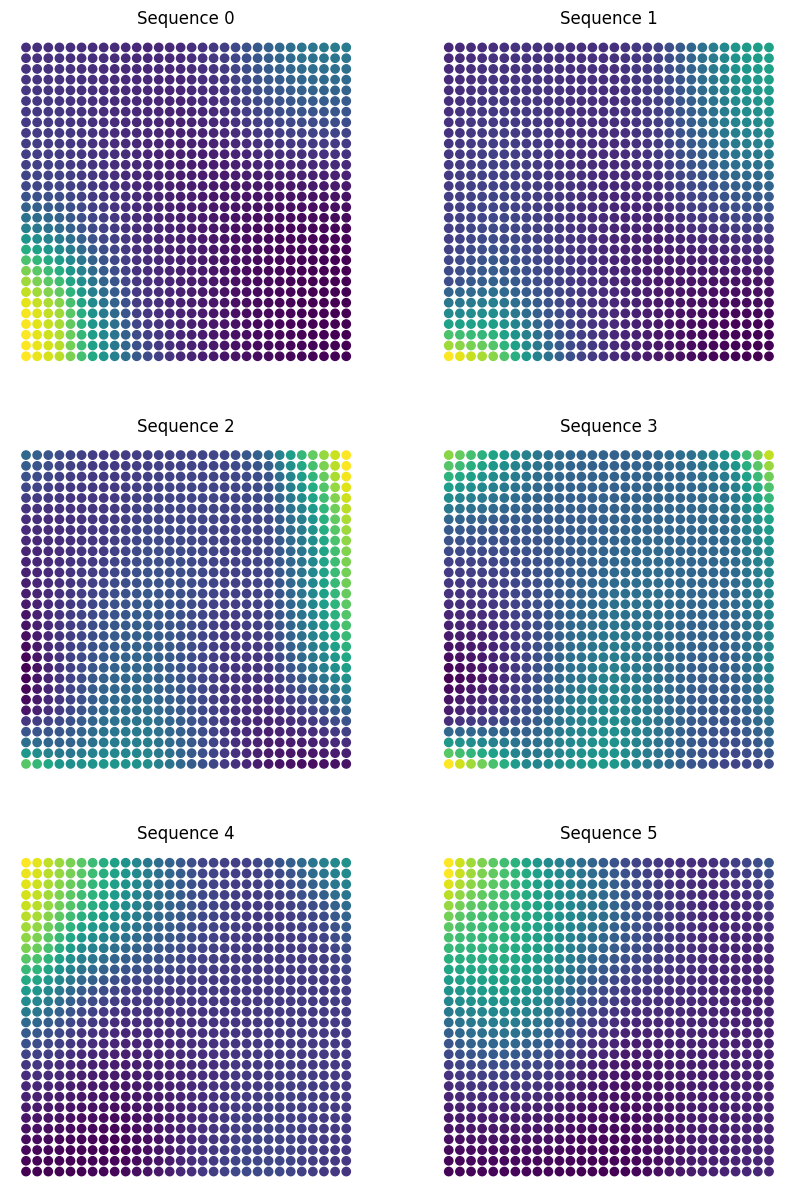

In [421]:
seq_obs = []

for i, batch_sequence in enumerate(test_loader):
    for j, batch in enumerate(batch_sequence):
        obs = batch[0]
        seq_obs.append(obs)
        if j > 4:
            break
    if i >= 0:
        break

f, ax = plt.subplots(3, 2, figsize=(10, 15))
it = 0
for i in range(3):
    for j in range(2):
        obs = seq_obs[i*2 + j]
        ax[i, j].scatter(obs.xs[it], obs.ys[it], c=obs.values[it])
        ax[i, j].set_title(f"Sequence {i*2 + j}")
        ax[i, j].axis("off")
plt.show()


In [416]:

env_params = EnvParams.load_from_yaml("/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/envs/env_cfg.yaml")

robot_type = "dubins2d"
cfg_file = f"agents/{robot_type}_cfg.yaml"

sensor_params = DownwardsSensorParams(
    world_x_size=env_params.world_x_size,
    world_y_size=env_params.world_y_size,
    points_in_range=8,
    fov_size_degrees=15
)

# ==== DATA LOADING ====
num_collection_data = 1e4
replay_buffer = GenericReplayBuffer(buffer_size=num_collection_data, data_keys=[])
replay_buffer.load_from_file('/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/misc/collection_data_static_1_0113_1845/replay_buffer.npz')

# ==== GP SETUP ====
datasize = replay_buffer.current_size

train_split = 0.9
test_split = 0.1

train_idx = np.arange(int(datasize * train_split))
test_idx = np.arange(int(datasize * train_split), int(datasize * (train_split + test_split)))


# ==== CONFIGURACION ====
BATCH_SIZE = 1
EPOCHS = 20
SEQ_LEN = 10 # Pasos de entrenamiento efectivos

# CAMBIO 2: Filtramos índices para asegurar tener espacio para SEQ_LEN + 1
valid_train_indices = train_idx[train_idx < (datasize - (SEQ_LEN + 1))]

train_dataset = VAESSMSequenceDataset(replay_buffer, SEQ_LEN, valid_train_indices)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=vaessm_collate_fn,
    num_workers=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vaessm = ScalarFieldVAESSM(params=VAESSMParams()).to(device)
vaessm.load_state_dict(torch.load("/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/vaessm_6th.pt"))

# 1. PREPARACIÓN DATASET TEST
valid_test_indices = test_idx[test_idx < (datasize - SEQ_LEN)]
test_dataset = VAESSMSequenceDataset(replay_buffer, SEQ_LEN, valid_test_indices)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, # No es necesario mezclar para test
    collate_fn=vaessm_collate_fn,
    num_workers=0
)

# 2. BUCLE DE EVALUACIÓN
vaessm.eval() # Importante: poner en modo evaluación (apaga dropout, etc.)
test_total_loss = 0
test_total_mse = 0
total_steps = 0

# Guardamos datos del último batch para visualizar después
batches_data = []

with torch.no_grad(): # Desactiva el cálculo de gradientes para ahorrar memoria/tiempo
    for batch_idx, batch_sequence in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluando"):
        
        # Inicializar estados
        current_batch_size = batch_sequence[0][1].shape[0]
        prev_h = torch.zeros(current_batch_size, vaessm.params.deter_dim).to(device)
        prev_z = torch.zeros(current_batch_size, vaessm.params.stoch_dim).to(device)
        
        # Listas para reconstruir la secuencia completa (para visualización)
        seq_targets = []
        seq_preds = []
        seq_xs = []
        seq_ys = []
        seq_pred_grids = []
        
        inputs = batch_sequence[:-1]
        targets = batch_sequence[1:]

        for t, ((obs_in, act_in, done_in), (obs_target, _, done_target)) in enumerate(zip(inputs, targets)):
            # Mover a device
            obs_in.xs = obs_in.xs.to(device)
            obs_in.ys = obs_in.ys.to(device)
            obs_in.values = obs_in.values.to(device)
            if obs_in.mask is not None: obs_in.mask = obs_in.mask.to(device)
            act_in = act_in.to(device)
            done_in = done_in.to(device)

            act_in = torch.zeros_like(act_in)

            # Forward (Inferencia)
            h, z, prior_dist, post_dist, pred_dist = vaessm(
                prev_h=prev_h,
                prev_z=prev_z,
                prev_action=act_in,
                dones=done_in,
                obs=obs_in,
                query_obs=obs_target,
            )

            _, _, _, _, _ = vaessm(
                prev_h=prev_h,
                prev_z=prev_z,
                prev_action=act_in,
                dones=done_in,
                query_obs=obs_target 
            )

            # Forward (Inferencia grid)
            xs = torch.linspace(obs_in.xs.min(), obs_in.xs.max(), 50)
            ys = torch.linspace(obs_in.ys.min(), obs_in.ys.max(), 50)
            ys, xs = torch.meshgrid(xs, ys)
            xs = xs.ravel().unsqueeze(0)
            ys = ys.ravel().unsqueeze(0)
            obs_grid_target = ObsVAESSM(xs=xs, ys=ys, values=None, mask=None)
            _, _, _, _, pred_grid_dist = vaessm(
                prev_h=prev_h,
                prev_z=prev_z,
                prev_action=act_in,
                dones=done_in,
                query_obs=obs_grid_target 
            )
            
            # Cálculos de Loss (Igual que en train)
            kl_loss = torch.distributions.kl_divergence(post_dist, prior_dist).sum(dim=-1)
            gt_values = obs_target.values.unsqueeze(-1)
            log_likelihood = pred_dist.log_prob(gt_values).mean()
            
            target = obs_target.values
            pred = pred_dist.sample()
            pred_grid = pred_grid_dist.sample()
            pred_grid = pred_grid.reshape(50, 50)
            
            loss_step = kl_loss - log_likelihood
            
            test_total_loss += loss_step.item()
            test_total_mse += -log_likelihood.item()
            total_steps += 1
            
            # Actualizar estados
            prev_h = h
            prev_z = z
            
            # Guardar datos para visualización (solo del paso t)
            seq_targets.append(target.cpu())
            seq_preds.append(pred.cpu())
            seq_xs.append(obs_target.xs.cpu())
            seq_ys.append(obs_target.ys.cpu())
            seq_pred_grids.append(pred_grid.cpu())

        # Guardamos la última secuencia completa procesada
        batch_data = {
            'xs': seq_xs, 
            'ys': seq_ys, 
            'targets': seq_targets, 
            'preds': seq_preds,
            'pred_grids': seq_pred_grids
        }
        batches_data.append(batch_data)

avg_test_loss = test_total_loss / total_steps
avg_test_mse = test_total_mse / total_steps

(f"\nRESULTADOS TEST:")
print(f"Avg Loss (ELBO): {avg_test_loss:.4f}")
print(f"Avg MSE (Reconstruction Error): {avg_test_mse:.6f}")


ADVERTENCIA: Las claves cargadas (['actions', 'state', 'smoke_values', 'smoke_value_positions', 'done']) o el tamaño (1000) 
no coinciden con la configuración actual ([], 10000). 
Usando la configuración y datos cargados.
Buffer cargado exitosamente. Tamaño actual: 1000
Using device: cpu


Evaluando: 100%|██████████| 90/90 [00:02<00:00, 35.08it/s]

Avg Loss (ELBO): 0.1233
Avg MSE (Reconstruction Error): -0.055192


In [400]:
kl_loss

tensor([0.0098])

Loss sample 0.3544417 1.4481789 3.774464e-05


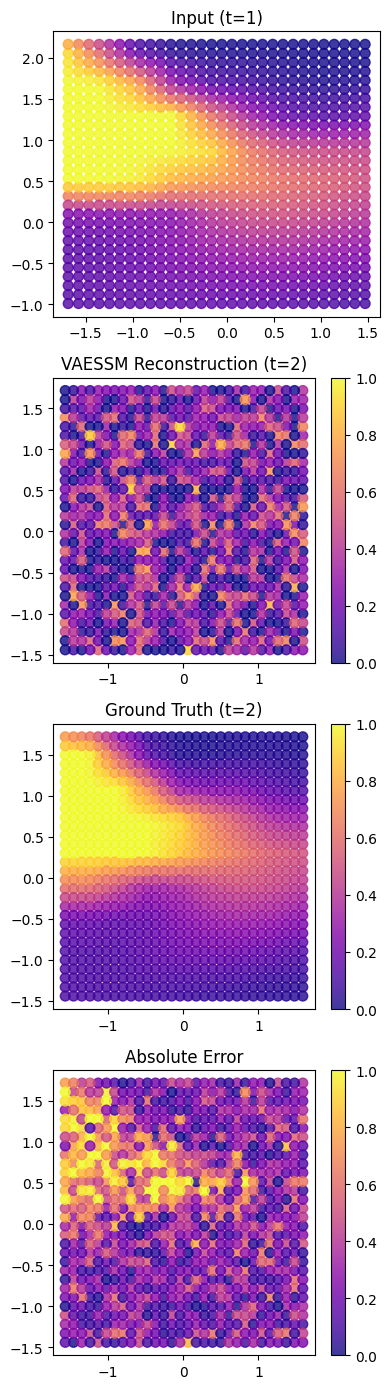

Visualización generada.


In [423]:

# 3. VISUALIZACIÓN
# Vamos a graficar un paso de tiempo aleatorio de la última secuencia del último batch
batch_idx = np.random.randint(0, len(batches_data))
last_batch_data = batches_data[batch_idx]
if last_batch_data is not None:
    import matplotlib.pyplot as plt
    
    # Elegimos un paso de tiempo (ej. el paso 5 de la secuencia)
    time_step = min(2, len(last_batch_data['xs']) - 1)
    # Elegimos un elemento del batch (ej. el índice 0)
    batch_elem = 0
    
    # Extraer datos
    # xs es lista de tensores [Batch, N_points]. Queremos [time_step][batch_elem]
    xs = last_batch_data['xs'][time_step][batch_elem].numpy()
    ys = last_batch_data['ys'][time_step][batch_elem].numpy()
    prev_xs = last_batch_data['xs'][time_step-1][batch_elem].numpy()
    prev_ys = last_batch_data['ys'][time_step-1][batch_elem].numpy()
    truth = last_batch_data['targets'][time_step][batch_elem].squeeze().numpy()
    prev_truth = last_batch_data['targets'][time_step-1][batch_elem].squeeze().numpy()
    pred = last_batch_data['preds'][time_step][batch_elem].squeeze().numpy()
    pred_grid = last_batch_data['pred_grids'][time_step].squeeze().numpy()
    
    fig, axes = plt.subplots(4, 1, figsize=(4, 14))
    
    # Configuración común de scatter
    sc_args = {'s': 50, 'cmap': 'plasma', 'alpha': 0.8}
    
    # Plot Ground Truth
    vmin, vmax = 0, 1.0
    im1 = axes[2].scatter(xs, ys, c=truth, vmin=vmin, vmax=vmax, **sc_args)
    axes[2].set_title(f"Ground Truth (t={time_step})")
    plt.colorbar(im1, ax=axes[2])
    
    # Plot Predicción
    im2 = axes[1].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, **sc_args)
    axes[1].set_title(f"VAESSM Reconstruction (t={time_step})")
    plt.colorbar(im2, ax=axes[1])

    # Plot Input
    im3 = axes[0].scatter(prev_xs, prev_ys, c=prev_truth, vmin=vmin, vmax=vmax, **sc_args)
    axes[0].set_title(f"Input (t={time_step-1})")
    
    # Plot Error Absoluto
    error = np.abs(truth - pred)
    im4 = axes[3].scatter(xs, ys, c=error, **sc_args, vmin=vmin, vmax=vmax)
    axes[3].set_title("Absolute Error")
    plt.colorbar(im4, ax=axes[3])

    # im4 = axes[3].imshow(pred_grid, vmin=vmin, vmax=vmax, cmap='plasma', origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
    # axes[3].set_title(f"VAESSM Reconstruction (t={time_step})")
    # plt.colorbar(im4, ax=axes[3])

    # im5 = axes[3].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, s = 1, cmap='plasma')

    sample_loss = np.abs(truth - pred) 
    print("Loss sample", sample_loss.mean(), sample_loss.max(), sample_loss.min())
    
    # for ax in axes:
    #     ax.set_xlim(-env_params.world_x_size/2, env_params.world_x_size/2)
    #     ax.set_ylim(-env_params.world_y_size/2, env_params.world_y_size/2)
    #     ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("Visualización generada.")

In [403]:
batches_data

[]

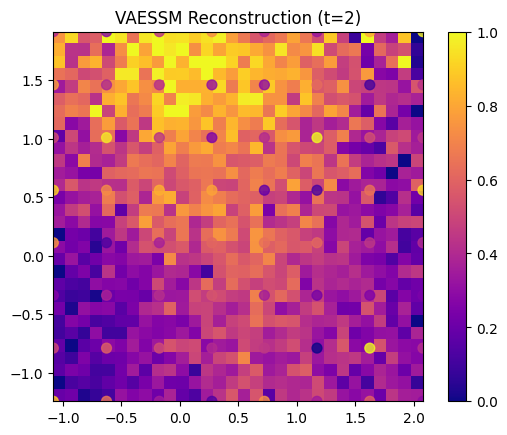

In [224]:
plt.imshow(pred_grid, vmin=vmin, vmax=vmax, cmap='plasma', origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
plt.title(f"VAESSM Reconstruction (t={time_step})")
plt.colorbar()

plt.scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, **sc_args)

Text(0.5, 1.0, 'transpose')

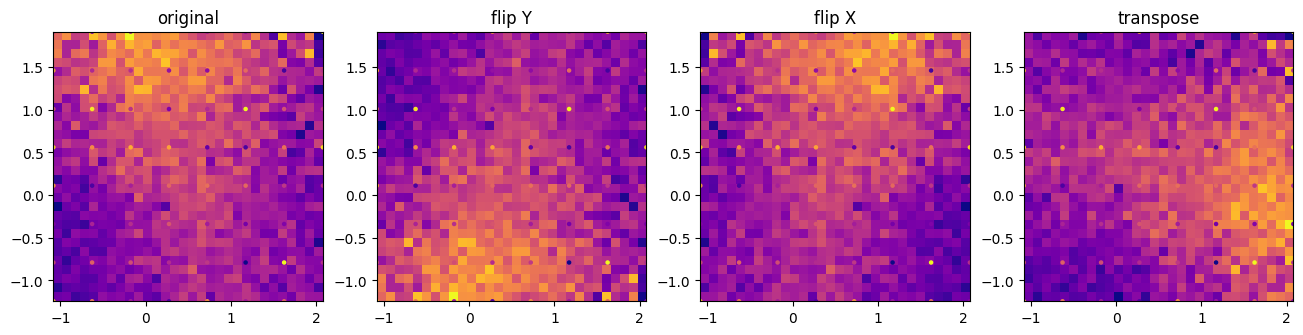

In [230]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))


axs[0].imshow(pred_grid, origin="lower", cmap='plasma', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
axs[0].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, cmap='plasma', s=5)
axs[0].set_title("original")

axs[1].imshow(pred_grid[::-1, :], origin="lower", cmap='plasma', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
axs[1].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, cmap='plasma', s=5)
axs[1].set_title("flip Y")

axs[2].imshow(pred_grid[:, ::-1], origin="lower", cmap='plasma', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
axs[2].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, cmap='plasma', s=5)
axs[2].set_title("flip X")

axs[3].imshow(pred_grid.T, origin="lower", cmap='plasma', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
axs[3].scatter(xs, ys, c=pred, vmin=vmin, vmax=vmax, cmap='plasma', s=5)
axs[3].set_title("transpose")


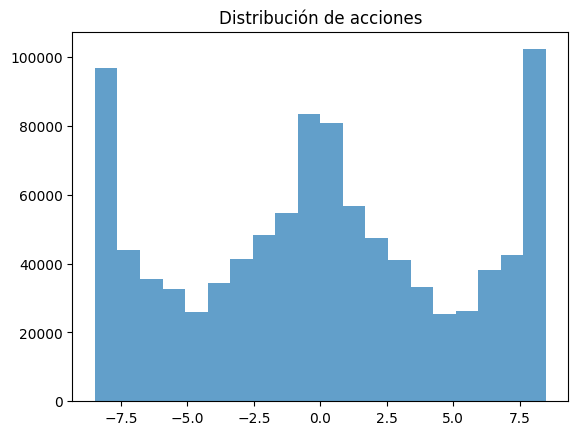

In [25]:
plt.figure()
plt.hist(np.sum(all_actions_np, axis=1), bins=20, alpha=0.7)
plt.title("Distribución de acciones")
plt.show()

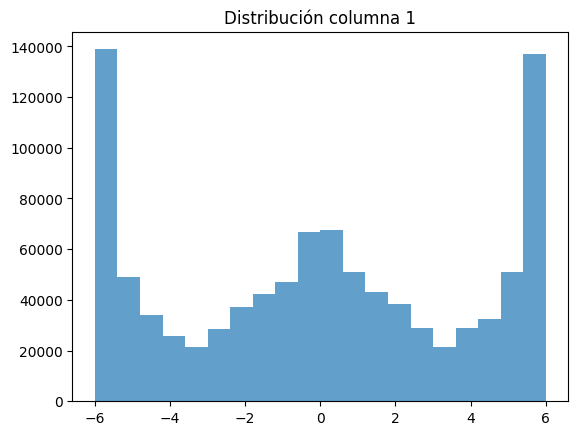

In [26]:
plt.figure()
plt.hist(all_actions_np[:, 0], bins=20, alpha=0.7)
plt.title("Distribución columna 1")
plt.show()

In [21]:
class PointEncoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(PointEncoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  # nn.Linear(h_dim, h_dim),
                  # nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)

    def forward(self, obs: ObsRSSM):
        """
        mask: Tensor Bool (Batch, N). True = Padding (Ignorar), False = Real.
        """
        pos = torch.stack([obs.xs, obs.ys], dim=-1)
        values = obs.values.unsqueeze(-1)
        x = torch.cat([pos, values], dim=-1)
        return self.input_to_hidden(x)

class MuSigmaEncoder(nn.Module):
    def __init__(self, r_dim, z_dim):
        super(MuSigmaEncoder, self).__init__()

        self.r_dim = r_dim
        self.z_dim = z_dim

        self.r_to_hidden = nn.Linear(r_dim, r_dim)
        self.hidden_to_mu = nn.Linear(r_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(r_dim, z_dim)

    def forward(self, r):
        hidden = torch.relu(self.r_to_hidden(r))
        mu = self.hidden_to_mu(hidden)
        sigma =  0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden)) #  
        return mu, sigma
        
class PointDecoder(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, y_dim):
        super(PointDecoder, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  # nn.Linear(h_dim, h_dim),
                  # nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, z: torch.Tensor, query_obs: ObsRSSM):
        batch_size, num_points = query_obs.xs.shape
        
        # Embed query positions
        x = torch.stack([query_obs.xs, query_obs.ys], dim=-1)
        
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)
        # Input is concatenation of z with every row of x
        input_pairs = torch.cat((x_flat, z_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)
        # Reshape output into expected shape
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.9 * F.softplus(pre_sigma)+ 0.1 
        return mu, sigma

from torch.distributions import Normal

class AttentionAggregator(nn.Module):
    def __init__(self, r_dim, h_dim, num_heads=4):
        super().__init__()
        self.query_proj = nn.Linear(r_dim, h_dim)
        self.key_proj   = nn.Linear(r_dim, h_dim)
        self.value_proj = nn.Linear(r_dim, h_dim)

        self.attn = nn.MultiheadAttention(
            embed_dim=h_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.out_proj = nn.Linear(h_dim, r_dim)

    def forward(self, r_i):
        q = r_i.mean(dim=1, keepdim=True)  # (B,1,r_dim)

        Q = self.query_proj(q)             # (B,1,h)
        K = self.key_proj(r_i)             # (B,N,h)
        V = self.value_proj(r_i)           # (B,N,h)

        attn_out, _ = self.attn(Q, K, V)   # (B,1,h)

        r = self.out_proj(attn_out.squeeze(1))  # (B,r_dim)
        return r


class NeuralProcess(nn.Module):
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(NeuralProcess, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = PointEncoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = MuSigmaEncoder(r_dim, z_dim)
        self.xz_to_y = PointDecoder(x_dim, z_dim, h_dim, y_dim)
        self.attention_aggregator = AttentionAggregator(r_dim, h_dim)

    def aggregate(self, r_i):
        if False:
            return torch.mean(r_i, dim=1)
        else:
            return self.attention_aggregator(r_i)

    def xy_to_mu_sigma(self, obs):
        batch_size, num_points = obs.xs.size()
        # Encode each point into a representation r_i
        r_i_flat = self.xy_to_r(obs)
        # Reshape tensors into batches
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)
        # Aggregate representations r_i into a single representation r
        r = self.aggregate(r_i)
        # Return parameters of distribution
        return self.r_to_mu_sigma(r)

    def forward(self, obs, query_obs):
        # Infer quantities from tensor dimensions
        batch_size, num_context= obs.xs.size()
        _, num_target = query_obs.xs.size()

        # Encode target and context (context needs to be encoded to
        # calculate kl term)
        mu_target, sigma_target = self.xy_to_mu_sigma(query_obs)
        mu_context, sigma_context = self.xy_to_mu_sigma(obs)
        # Sample from encoded distribution using reparameterization trick
        q_target = Normal(mu_target, sigma_target)
        q_context = Normal(mu_context, sigma_context)
        z_sample = q_target.rsample()
        # Get parameters of output distribution
        y_pred_mu, y_pred_sigma = self.xz_to_y(z_sample, query_obs)
        p_y_pred = Normal(y_pred_mu, y_pred_sigma)

        return p_y_pred, q_target, q_context

In [22]:
class ScalarFieldRSSM(nn.Module):
    def __init__(self, params: RSSMParams):
        super().__init__()
        self.params = params
        self.encoder = PointEncoder(params)
        self.decoder = PointDecoder(params)

        rnn_input_dim = params.stoch_dim + params.action_dim
        self.gru = nn.GRUCell(rnn_input_dim, params.deter_dim)
        
        # Prior Network
        self.prior_net = nn.Sequential(
            nn.Linear(params.deter_dim, params.prior_dim), nn.ELU(),
            nn.Linear(params.prior_dim, 2 * params.stoch_dim)
        )
        
        # Posterior Network
        self.posterior_net = nn.Sequential(
            nn.Linear(params.deter_dim + params.embed_dim, params.posterior_dim), nn.ELU(),
            nn.Linear(params.posterior_dim, 2 * params.stoch_dim)
        )

    def forward(self, prev_h: torch.Tensor, prev_z: torch.Tensor, prev_action: torch.Tensor, dones: torch.Tensor, obs: ObsRSSM | None = None, query_obs: ObsRSSM | None = None):
        """
        dones: Tensor (Batch, 1) o (Batch). 
               True/1.0 indica que el paso PREVIO fue el final de un episodio, 
               por lo que este paso inicia 'limpio'.
        """
        # Ajustar dimensiones de dones para broadcasting (B) -> (B, 1)
        if dones.dim() == 1:
            dones = dones.unsqueeze(1)
        
        # 0. MÁSCARA DE RESET
        # Si done=1, (1-done)=0 -> El estado se vuelve cero (reset).
        # Si done=0, (1-done)=1 -> El estado se mantiene.
        mask = 1.0 - dones.float()
        
        prev_h = prev_h * mask
        prev_z = prev_z * mask

        # 1. h_t = f(z_t-1, h_t-1)
        # Ahora la GRU recibe ceros si hubo un done, iniciando efectivamente una nueva secuencia
        rnn_input = torch.cat([prev_z, prev_action], dim=-1)
        h = self.gru(rnn_input, prev_h)
        
        # 2. Prior z_t ~ p(z_t | h_t)
        prior_out = self.prior_net(h)
        p_mu, p_std = torch.chunk(prior_out, 2, dim=1)
        p_std = F.softplus(p_std) + 0.1
        prior_dist = torch.distributions.Normal(p_mu, p_std)
        
        # 3. Posterior (Realidad)
        if obs is not None:
            embed = self.encoder(obs)
            
            # Posterior z_t ~ q(z_t | h_t, x_t)
            post_in = torch.cat([h, embed], dim=1)
            post_out = self.posterior_net(post_in)
            q_mu, q_std = torch.chunk(post_out, 2, dim=1)
            q_std = F.softplus(q_std) + 0.1
            post_dist = torch.distributions.Normal(q_mu, q_std)
            z = post_dist.rsample()
        else:
            post_dist = None
            z = prior_dist.rsample()
            
        # 4. Decodificar
        decoded_values = None
        if query_obs is not None:
            feat = torch.cat([h, z], dim=1)
            decoded_values = self.decoder(feat, query_obs)
            
        return h, z, prior_dist, post_dist, decoded_values

def collate_variable_batch(batch_list: list[ObsRSSM]):
    """
    Toma una lista de observaciones (obs).
    """
    
    obs_xys = [torch.stack([b.xs, b.ys], dim=-1) for b in batch_list]
    obs_vals = [b.values for b in batch_list if b.values is not None]
    
    # Pad Sequence (obs)
    obs_xy_pad = pad_sequence(obs_xys, batch_first=True, padding_value=0)

    obs_lens = torch.tensor([len(t) for t in obs_xys])
    obs_max_len = obs_xy_pad.shape[1]
    obs_mask = (torch.arange(obs_max_len)[None, :] >= obs_lens[:, None]).bool()

    if obs_vals:
        obs_val_pad = pad_sequence(obs_vals, batch_first=True, padding_value=0)
    else:
        obs_val_pad = None

    batch_obsrssm = ObsRSSM(
        xs=obs_xy_pad[:, :, 0],
        ys=obs_xy_pad[:, :, 1],
        values=obs_val_pad,
        mask=obs_mask
    )
    return batch_obsrssm

class RSSMSequenceDataset(Dataset):
    def __init__(self, replay_buffer, sequence_length, valid_indices):
        self.buffer = replay_buffer
        self.seq_len = sequence_length + 1 
        self.indices = valid_indices
        
        # DEFINIR LÍMITES (Es bueno tenerlos como constantes)
        self.max_coord = 50.0

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        
        # Usamos nombres distintos para las listas acumuladoras
        # para no confundirlas con los datos de cada paso
        xs_seq, ys_seq, vals_seq, acts_seq, dones_seq = [], [], [], [], []
        
        for t in range(self.seq_len):
            curr_idx = start_idx + t
            data = self.buffer.get_from_index(curr_idx)
            
            # 1. Obtener datos crudos (Numpy)
            raw_xs = data["smoke_value_positions"][:, 0]
            raw_ys = data["smoke_value_positions"][:, 1]
            raw_vals = data["smoke_values"]

            indxs = np.arange(len(raw_xs))
            np.random.shuffle(indxs)

            raw_xs = raw_xs[indxs]
            raw_ys = raw_ys[indxs]
            raw_vals = raw_vals[indxs]

            raw_done = data["done"] # O "dones" según tu buffer

            v_local, w_local = data["actions"]
            r_theta = data["state"][2] # <--- Asegúrate que esto existe en tu buffer
            r_x, r_y = data["state"][0], data["state"][1]
            
            # Proyectar velocidad al marco global
            global_vx = v_local * np.cos(r_theta)
            global_vy = v_local * np.sin(r_theta)
            
            # Acción efectiva: [vel_x, vel_y, rotacion]
            action_vec = torch.tensor([global_vx, global_vy, w_local], dtype=torch.float32)

            # 3. Normalización (Igual que antes)
            norm_xs = (raw_xs - r_x)
            norm_ys = (raw_ys - r_y)

            # 3. Guardar en las listas (Convirtiendo a Tensor Float)
            xs_seq.append(torch.from_numpy(norm_xs).float())
            ys_seq.append(torch.from_numpy(norm_ys).float())
            
            # Los valores ya están en 0-1, así que entran directo
            # .squeeze() es importante si vienen como (N, 1)
            vals_seq.append(torch.from_numpy(raw_vals).float().squeeze())
            
            dones_seq.append(float(raw_done))
            acts_seq.append(action_vec)
        return xs_seq, ys_seq, vals_seq, torch.stack(acts_seq), torch.tensor(dones_seq)

def rssm_collate_fn(batch):
    """
    Transforma una lista de secuencias [(seq1), (seq2)...] 
    en un formato batch-major para el RSSM (Time, Batch, ...).
    """
    # batch es una lista de tuplas (xs, ys, vals, dones) de longitud B
    # Cada elemento de la tupla es una lista de longitud L (la secuencia)
    
    seq_len = len(batch[0][0])
    batch_size = len(batch)
    
    # Estructura final deseada: Una lista de longitud L, donde cada elemento
    # es un ObsRSSM que contiene el batch (B) combinado.
    
    batched_steps = [] # Lista de L pasos
    
    # Transponer: iterar por tiempo t
    for t in range(seq_len):
        batch_xs_t = []
        batch_ys_t = []
        batch_vals_t = []
        batch_acts_t = [] # Nueva lista
        batch_dones_t = []
        
        for b in range(batch_size):
            # batch[b] es la secuencia b
            # batch[b][0] son las xs de esa secuencia
            # batch[b][0][t] son las xs en el tiempo t
            batch_xs_t.append(batch[b][0][t])
            batch_ys_t.append(batch[b][1][t])
            batch_vals_t.append(batch[b][2][t])
            batch_acts_t.append(batch[b][3][t]) # Agregar acciones
            batch_dones_t.append(batch[b][4][t])
        
        # Ahora usamos tu función 'collate_variable_batch' para este paso de tiempo t
        # Primero creamos objetos ObsRSSM temporales para usar tu función existente
        # (O idealmente, modificas collate_variable_batch para aceptar listas crudas)
        step_obs_list = []
        for i in range(batch_size):
            step_obs_list.append(ObsRSSM(
                xs=batch_xs_t[i],
                ys=batch_ys_t[i],
                values=batch_vals_t[i]
            ))
            
        batched_obs_t = collate_variable_batch(step_obs_list)
        batched_dones_t = torch.tensor(batch_dones_t).float().unsqueeze(1) # (B, 1)
        batched_acts_t = torch.stack(batch_acts_t)
        
        batched_steps.append((batched_obs_t, batched_acts_t, batched_dones_t))
        
    return batched_steps

import torch.optim as optim

NameError: name 'RSSMParams' is not defined

In [23]:
env_params = EnvParams.load_from_yaml("/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/envs/env_cfg.yaml")

robot_type = "dubins2d"
cfg_file = f"agents/{robot_type}_cfg.yaml"

sensor_params = DownwardsSensorParams(
    world_x_size=env_params.world_x_size,
    world_y_size=env_params.world_y_size,
    points_in_range=8,
    fov_size_degrees=15
)

# ==== DATA LOADING ====
num_collection_data = 1e4
replay_buffer = GenericReplayBuffer(buffer_size=num_collection_data, data_keys=[])
replay_buffer.load_from_file('/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/misc/collection_data_1_1210_1530/replay_buffer.npz')

# ==== GP SETUP ====

datasize = replay_buffer.current_size

train_split = 0.8
test_split = 0.2

train_idx = np.arange(int(datasize * train_split))
test_idx = np.arange(int(datasize * train_split), int(datasize * (train_split + test_split)))


# ==== CONFIGURACION ====
BATCH_SIZE = 24
EPOCHS = 20
SEQ_LEN = 10 # Pasos de entrenamiento efectivos

# CAMBIO 2: Filtramos índices para asegurar tener espacio para SEQ_LEN + 1
valid_train_indices = train_idx[train_idx < (datasize - (SEQ_LEN + 1))]

train_dataset = RSSMSequenceDataset(replay_buffer, SEQ_LEN, valid_train_indices)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=rssm_collate_fn,
    num_workers=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# rssm = ScalarFieldRSSM(params=RSSMParams()).to(device)
# vae = ScalarFieldVAE(params=RSSMParams()).to(device)
# nproc = NeuralProcess(x_dim=2, y_dim=1, r_dim=128, z_dim=128, h_dim=128).to(device)
vaessm = ScalarFieldVAESSM(params=VAESSMParams()).to(device)
optimizer = optim.Adam(vaessm.parameters(), lr=4e-4)

ADVERTENCIA: Las claves cargadas (['actions', 'state', 'smoke_values', 'smoke_value_positions', 'done']) o el tamaño (100000) 
no coinciden con la configuración actual ([], 10000). 
Usando la configuración y datos cargados.
Buffer cargado exitosamente. Tamaño actual: 100000


NameError: name 'RSSMSequenceDataset' is not defined

In [421]:

# ==== TRAINING LOOP ====
for epoch in range(EPOCHS):
    vaessm.train()
    total_loss = 0
    
    # tqdm para barra de progreso
    for batch_sequence in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        # batch_sequence es una lista de longitud SEQ_LEN + 1
        
        current_batch_size = batch_sequence[0][1].shape[0]
        
        prev_h = torch.zeros(current_batch_size, vaessm.params.deter_dim).to(device)
        prev_z = torch.zeros(current_batch_size, vaessm.params.stoch_dim).to(device)
        
        sequence_loss = 0
        
        # CAMBIO 3: Separar Inputs y Targets
        # inputs:  t=0 ... t=9
        # targets: t=1 ... t=10
        inputs = batch_sequence[:-1]
        targets = batch_sequence[1:]
        
        # Iteramos en pares (Input Actual, Target Futuro)
        for t, ((obs_in, act_in, done_in), (obs_target, _, done_target)) in enumerate(zip(inputs, targets)):
            
            # Mover a GPU
            obs_in.xs, obs_in.ys, obs_in.values = obs_in.xs.to(device), obs_in.ys.to(device), obs_in.values.to(device)
            if obs_in.mask is not None: obs_in.mask = obs_in.mask.to(device)
            
            obs_target.xs, obs_target.ys, obs_target.values = obs_target.xs.to(device), obs_target.ys.to(device), obs_target.values.to(device)
            if obs_target.mask is not None: obs_target.mask = obs_target.mask.to(device)
            
            done_in = done_in.to(device) # (B, 1)
            act_in = act_in.to(device) # [Batch, 3]

            obs_in.values = obs_in.values.squeeze()
            obs_target.values = obs_target.values.squeeze()

            # === FORWARD ===
            # 1. Obs Actual (t) -> Encoder -> Posterior
            # 2. Done Actual (t) -> Resetea estado si t era nuevo episodio
            # 3. Query Obs (t+1) -> Decoder predice valores en las posiciones de t+1
            h, z, prior_dist, post_dist, y_pred_dist = vaessm(
                prev_h=prev_h,
                prev_z=prev_z,
                prev_action=act_in, # <--- AQUI PASAMOS LA ACCION
                dones=done_in,     # Resetea memoria si el input actual es start de episodio
                obs=obs_in,        # Codifica t
                query_obs=obs_target # Decodifica (predice) en coordenadas de t+1
            )

            # === LOSS ===
            # A. KL Divergence (Latent Regularization)
            # Divergencia entre Prior (predicción sin ver obs) y Posterior (tras ver obs)
            raw_kl = kl_divergence(post_dist, prior_dist)
            raw_kl_vec = raw_kl.mean(dim=1)

            y_target = obs_target.values.unsqueeze(-1)
            log_likelihood = y_pred_dist.log_prob(y_target).mean()

            
            # Si tienes máscara de padding (obs.mask), aplícala aquí al promedio espacial:
            # if obs_target.mask is not None:
            #     valid_target = (~obs_target.mask).float()
            #     log_likelihood = (log_likelihood * valid_target).sum(dim=1) / valid_target.sum(dim=1).clamp(min=1)
            # else:
            #     log_likelihood = log_likelihood.mean(dim=1)
            
            # === MÁSCARA DE VALIDEZ TEMPORAL (CRUCIAL) ===
            # Si done_in es True, significa que el paso 't' fue terminal.
            # Por tanto, 't+1' pertenece a OTRO episodio. No hay relación causal.
            # Debemos anular la loss de predicción en este caso.
            valid_transition = (1.0 - done_in).squeeze() # (B,)
            
            # Loss total por sample
            kl_vec_valid = raw_kl_vec * valid_transition
            log_likelihood = log_likelihood * valid_transition
            
            # Promedio final solo sobre los elementos válidos
            step_loss = kl_vec_valid - log_likelihood
            sequence_loss += step_loss.mean()
            
            # Actualizar estados para el siguiente paso
            prev_h = h
            prev_z = z

        # Backprop
        optimizer.zero_grad()
        sequence_loss.backward()
        torch.nn.utils.clip_grad_norm_(vaessm.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += sequence_loss.item()
        pbar.set_postfix({"Loss": sequence_loss.item()})

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg Loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 3334/3334 [04:22<00:00, 12.69it/s]


Epoch 1/20 | Avg Loss: -6.2826


Epoch 2: 100%|██████████| 3334/3334 [04:08<00:00, 13.43it/s]


Epoch 2/20 | Avg Loss: -7.2259


Epoch 3: 100%|██████████| 3334/3334 [04:07<00:00, 13.49it/s]


Epoch 3/20 | Avg Loss: -7.8998


Epoch 4: 100%|██████████| 3334/3334 [04:06<00:00, 13.53it/s]


Epoch 4/20 | Avg Loss: -8.9221


Epoch 5: 100%|██████████| 3334/3334 [04:04<00:00, 13.65it/s]


Epoch 5/20 | Avg Loss: -9.3706


Epoch 6: 100%|██████████| 3334/3334 [04:03<00:00, 13.69it/s]


Epoch 6/20 | Avg Loss: -9.6443


Epoch 7: 100%|██████████| 3334/3334 [04:02<00:00, 13.76it/s]


Epoch 7/20 | Avg Loss: -9.7733


Epoch 8: 100%|██████████| 3334/3334 [04:00<00:00, 13.84it/s]


Epoch 8/20 | Avg Loss: -9.8544


Epoch 9: 100%|██████████| 3334/3334 [04:12<00:00, 13.21it/s]


Epoch 9/20 | Avg Loss: -9.9133


Epoch 10: 100%|██████████| 3334/3334 [04:01<00:00, 13.79it/s]


Epoch 10/20 | Avg Loss: -9.9631


Epoch 11: 100%|██████████| 3334/3334 [04:32<00:00, 12.23it/s]


Epoch 11/20 | Avg Loss: -10.0031


Epoch 12: 100%|██████████| 3334/3334 [04:39<00:00, 11.94it/s]


Epoch 12/20 | Avg Loss: -10.0388


Epoch 13: 100%|██████████| 3334/3334 [04:15<00:00, 13.05it/s]


Epoch 13/20 | Avg Loss: -10.1228


Epoch 14: 100%|██████████| 3334/3334 [04:11<00:00, 13.23it/s]


Epoch 14/20 | Avg Loss: -10.1953


Epoch 15: 100%|██████████| 3334/3334 [04:04<00:00, 13.65it/s]


Epoch 15/20 | Avg Loss: -10.2505


Epoch 16: 100%|██████████| 3334/3334 [04:00<00:00, 13.84it/s]


Epoch 16/20 | Avg Loss: -10.2991


Epoch 17: 100%|██████████| 3334/3334 [04:00<00:00, 13.84it/s]


Epoch 17/20 | Avg Loss: -10.3368


Epoch 18: 100%|██████████| 3334/3334 [03:58<00:00, 13.98it/s]


Epoch 18/20 | Avg Loss: -10.3643


Epoch 19: 100%|██████████| 3334/3334 [04:06<00:00, 13.52it/s]


Epoch 19/20 | Avg Loss: -10.3896


Epoch 20: 100%|██████████| 3334/3334 [04:05<00:00, 13.60it/s]

Epoch 20/20 | Avg Loss: -10.4064


In [ ]:
torch.save(vaessm.state_dict(), "vaessm.pt")


In [422]:
# 1. PREPARACIÓN DATASET TEST
valid_test_indices = test_idx[test_idx < (datasize - SEQ_LEN)]
test_dataset = RSSMSequenceDataset(replay_buffer, SEQ_LEN, valid_test_indices)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, # No es necesario mezclar para test
    collate_fn=rssm_collate_fn,
    num_workers=0
)

# 2. BUCLE DE EVALUACIÓN
vaessm.eval() # Importante: poner en modo evaluación (apaga dropout, etc.)
test_total_loss = 0
test_total_mse = 0
total_steps = 0

# Guardamos datos del último batch para visualizar después
batches_data = []

with torch.no_grad(): # Desactiva el cálculo de gradientes para ahorrar memoria/tiempo
    for batch_idx, batch_sequence in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluando"):
        
        # Inicializar estados
        current_batch_size = batch_sequence[0][1].shape[0]
        prev_h = torch.zeros(current_batch_size, vaessm.params.deter_dim).to(device)
        prev_z = torch.zeros(current_batch_size, vaessm.params.stoch_dim).to(device)
        
        # Listas para reconstruir la secuencia completa (para visualización)
        seq_targets = []
        seq_preds = []
        seq_xs = []
        seq_ys = []
        
        inputs = batch_sequence[:-1]
        targets = batch_sequence[1:]

        for t, ((obs_in, act_in, done_in), (obs_target, _, done_target)) in enumerate(zip(inputs, targets)):
            # Mover a device
            obs_in.xs = obs_in.xs.to(device)
            obs_in.ys = obs_in.ys.to(device)
            obs_in.values = obs_in.values.to(device)
            if obs_in.mask is not None: obs_in.mask = obs_in.mask.to(device)
            act_in = act_in.to(device)
            done_in = done_in.to(device)

            # Forward (Inferencia)
            h, z, prior_dist, post_dist, pred_dist = vaessm(
                prev_h=prev_h,
                prev_z=prev_z,
                prev_action=act_in,
                dones=done_in,
                obs=obs_in,
                query_obs=obs_target 
            )
            
            # Cálculos de Loss (Igual que en train)
            kl_loss = torch.distributions.kl_divergence(post_dist, prior_dist).mean()
            gt_values = obs_target.values.unsqueeze(-1)
            log_likelihood = pred_dist.log_prob(gt_values).mean()
            
            target = obs_target.values
            pred = pred_dist.mean
            
            loss_step = kl_loss - log_likelihood
            
            test_total_loss += loss_step.item()
            test_total_mse += -log_likelihood.item()
            total_steps += 1
            
            # Actualizar estados
            prev_h = h
            prev_z = z
            
            # Guardar datos para visualización (solo del paso t)
            seq_targets.append(target.cpu())
            seq_preds.append(pred.cpu())
            seq_xs.append(obs_in.xs.cpu())
            seq_ys.append(obs_in.ys.cpu())

        # Guardamos la última secuencia completa procesada
        batch_data = {
            'xs': seq_xs, 
            'ys': seq_ys, 
            'targets': seq_targets, 
            'preds': seq_preds
        }
        batches_data.append(batch_data)


Evaluando: 100%|██████████| 833/833 [00:21<00:00, 38.44it/s]



RESULTADOS TEST:
Avg Loss (ELBO): -1.0370
Avg MSE (Reconstruction Error): -1.071230
Loss sample 0.19182181 0.51128983 0.007836878


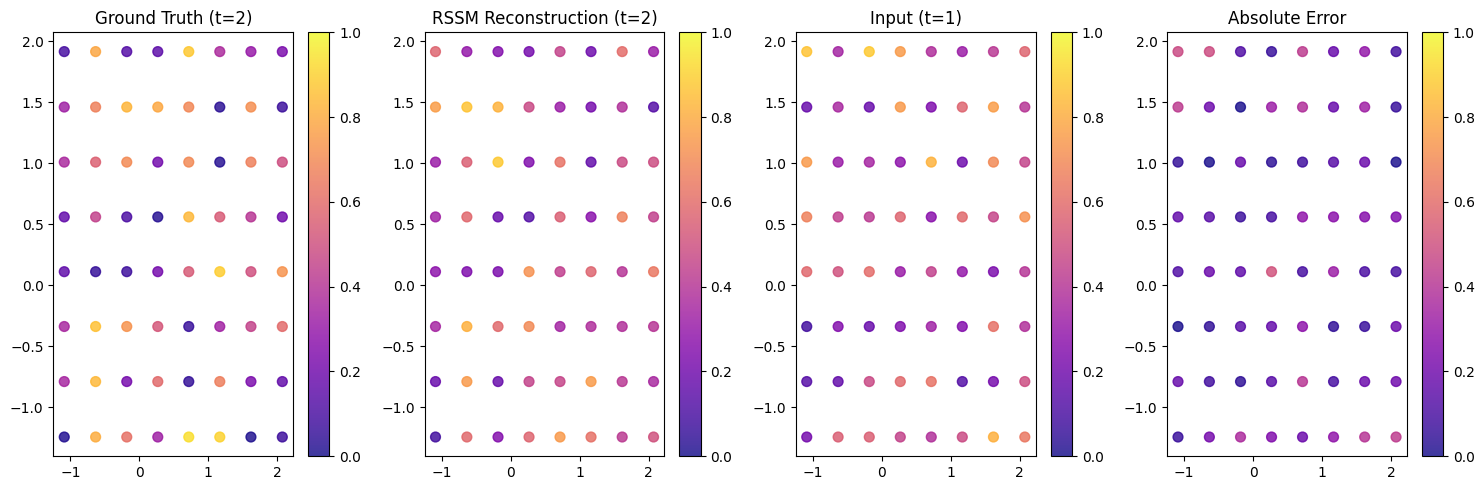

Visualización generada.


In [487]:

avg_test_loss = test_total_loss / total_steps
avg_test_mse = test_total_mse / total_steps

print(f"\nRESULTADOS TEST:")
print(f"Avg Loss (ELBO): {avg_test_loss:.4f}")
print(f"Avg MSE (Reconstruction Error): {avg_test_mse:.6f}")

# 3. VISUALIZACIÓN
# Vamos a graficar un paso de tiempo aleatorio de la última secuencia del último batch
batch_idx = np.random.randint(0, len(batches_data))
last_batch_data = batches_data[batch_idx]
if last_batch_data is not None:
    import matplotlib.pyplot as plt
    
    # Elegimos un paso de tiempo (ej. el paso 5 de la secuencia)
    time_step = min(2, len(last_batch_data['xs']) - 1)
    # Elegimos un elemento del batch (ej. el índice 0)
    batch_elem = 0
    
    # Extraer datos
    # xs es lista de tensores [Batch, N_points]. Queremos [time_step][batch_elem]
    xs = last_batch_data['xs'][time_step][batch_elem].numpy()
    ys = last_batch_data['ys'][time_step][batch_elem].numpy()
    prev_xs = last_batch_data['xs'][time_step-1][batch_elem].numpy()
    prev_ys = last_batch_data['ys'][time_step-1][batch_elem].numpy()
    truth = last_batch_data['targets'][time_step][batch_elem].squeeze().numpy()
    pred = last_batch_data['preds'][time_step][batch_elem].squeeze().numpy()
    
    # Filtrar padding (donde xs es 0 y ys es 0 usualmente, o usar máscara si la guardaste)
    # Asumiendo que padding es 0,0 y el mundo real no tiene 0,0 exacto o visualmente no importa
    mask = (xs != 0) | (ys != 0) 
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    # Configuración común de scatter
    sc_args = {'s': 50, 'cmap': 'plasma', 'alpha': 0.8}
    
    # Plot Ground Truth
    vmin, vmax = 0, 1.0
    im1 = axes[0].scatter(xs[mask], ys[mask], c=truth[mask], vmin=vmin, vmax=vmax, **sc_args)
    axes[0].set_title(f"Ground Truth (t={time_step})")
    plt.colorbar(im1, ax=axes[0])
    
    # Plot Predicción
    im2 = axes[1].scatter(xs[mask], ys[mask], c=pred[mask], vmin=vmin, vmax=vmax, **sc_args)
    axes[1].set_title(f"RSSM Reconstruction (t={time_step})")
    plt.colorbar(im2, ax=axes[1])

    # Plot Input
    im3 = axes[2].scatter(prev_xs[mask], prev_ys[mask], c=pred[mask], vmin=vmin, vmax=vmax, **sc_args)
    axes[2].set_title(f"Input (t={time_step-1})")
    plt.colorbar(im3, ax=axes[2])
    
    # Plot Error Absoluto
    error = np.abs(truth - pred)
    im4 = axes[3].scatter(xs[mask], ys[mask], c=error[mask], **sc_args, vmin=vmin, vmax=vmax)
    axes[3].set_title("Absolute Error")
    plt.colorbar(im4, ax=axes[3])

    sample_loss = np.abs(truth - pred) 
    print("Loss sample", sample_loss.mean(), sample_loss.max(), sample_loss.min())
    
    # for ax in axes:
    #     ax.set_xlim(-env_params.world_x_size/2, env_params.world_x_size/2)
    #     ax.set_ylim(-env_params.world_y_size/2, env_params.world_y_size/2)
    #     ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("Visualización generada.")

In [375]:
kl_vec_valid

tensor([3.7442e+12, 4.6327e+12, 5.4521e+12, 3.3581e+12, 4.8168e+12, 4.0730e+12,
        3.1586e+12, 4.6090e+12, 3.3520e+12, 3.3498e+12, 5.2377e+12, 5.5010e+12,
        3.5528e+12, 3.8564e+12, 3.4506e+12, 4.4304e+12, 5.7982e+12, 5.9258e+12,
        5.2770e+12, 5.4423e+12, 5.1404e+12, 3.7723e+12, 3.3405e+12, 5.1540e+12],
       grad_fn=<MulBackward0>)

In [376]:
log_likelihood

tensor([-1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18,
        -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18,
        -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18,
        -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18,
        -1.0302e+18, -1.0302e+18, -1.0302e+18, -1.0302e+18],
       grad_fn=<MulBackward0>)

In [372]:
prior_dist.mean


tensor([[-1.6715,  1.1024, -1.3502,  ..., -0.1258, -1.3851,  1.2970],
        [-1.6570,  1.1156, -1.2895,  ..., -0.1434, -1.3512,  1.3144],
        [-1.6909,  1.1250, -1.3733,  ..., -0.2312, -1.3823,  1.3031],
        ...,
        [-1.6318,  1.1060, -1.2912,  ..., -0.1531, -1.3567,  1.2714],
        [-1.7580,  1.1299, -1.4413,  ..., -0.1507, -1.4423,  1.3373],
        [-1.6536,  1.1381, -1.3427,  ..., -0.1521, -1.4157,  1.3241]],
       grad_fn=<AddmmBackward0>)

In [300]:
from torch.distributions.kl import kl_divergence

# ==== TRAINING LOOP ====
for epoch in range(EPOCHS):
    nproc.train()
    total_loss = 0
    
    # tqdm para barra de progreso
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_sequence in pbar:
        # batch_sequence es una lista de longitud 1
        current_batch_size = batch_sequence[0][1].shape[0]

        batch = batch_sequence[0]

        obs = batch[0]

        x_context = obs.xs

        p_y_pred, q_target, q_context = nproc(obs, obs)
        y_target = obs.values.unsqueeze(-1)

        # log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        log_likelihood = p_y_pred.log_prob(y_target).mean()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        # kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        loss = -log_likelihood #+ kl

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nproc.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()


    print("Epoch: ", epoch, "Loss: ", total_loss / len(train_loader))


        

    






Epoch 1: 100%|██████████| 2084/2084 [00:39<00:00, 53.36it/s]


Epoch:  0 Loss:  -0.6905562634542521


Epoch 2: 100%|██████████| 2084/2084 [00:40<00:00, 51.27it/s]


Epoch:  1 Loss:  -0.7854472738824742


Epoch 3: 100%|██████████| 2084/2084 [00:39<00:00, 53.31it/s]


Epoch:  2 Loss:  -0.8737973263505096


Epoch 4: 100%|██████████| 2084/2084 [00:38<00:00, 53.81it/s]


Epoch:  3 Loss:  -1.050899041305348


Epoch 5: 100%|██████████| 2084/2084 [00:40<00:00, 51.54it/s]


Epoch:  4 Loss:  -1.097387775549962


Epoch 6: 100%|██████████| 2084/2084 [00:50<00:00, 41.45it/s]


Epoch:  5 Loss:  -1.1251907375517824


Epoch 7: 100%|██████████| 2084/2084 [00:58<00:00, 35.65it/s]


Epoch:  6 Loss:  -1.145827227041497


Epoch 8: 100%|██████████| 2084/2084 [00:54<00:00, 38.37it/s]


Epoch:  7 Loss:  -1.1609943282867348


Epoch 9: 100%|██████████| 2084/2084 [00:48<00:00, 42.76it/s]


Epoch:  8 Loss:  -1.1713408681344162


Epoch 10: 100%|██████████| 2084/2084 [00:53<00:00, 38.85it/s]

Epoch:  9 Loss:  -1.1843436309449276


In [ ]:
mu_target, sigma_target = nproc.xy_to_mu_sigma(obs)
mu_target.std

tensor(0.9910, grad_fn=<StdBackward0>)

In [260]:
kl

tensor(0., grad_fn=<SumBackward0>)

Loss:  0.012718643993139267
Loss:  0.015448205173015594
Loss:  0.03173001483082771


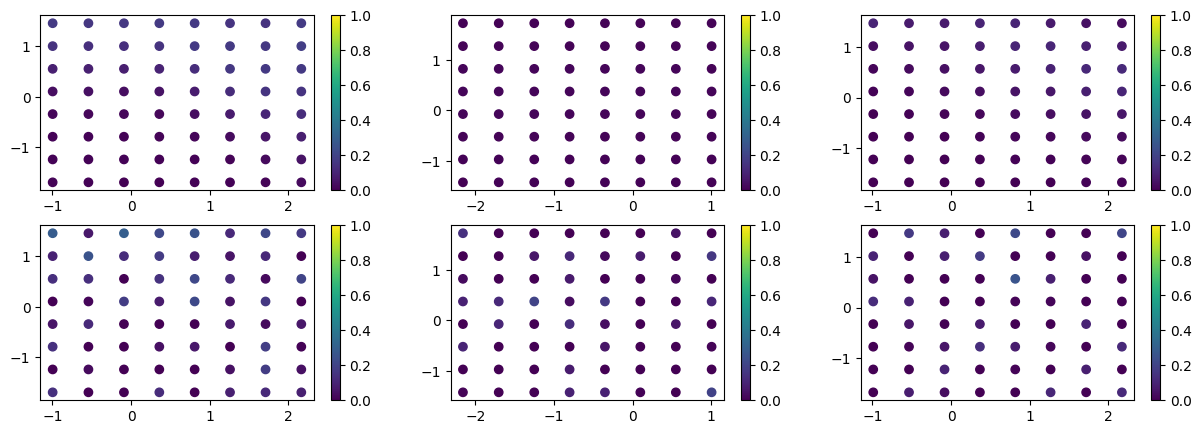

In [329]:
valid_test_indices = test_idx[test_idx < (datasize - SEQ_LEN)]
test_dataset = RSSMSequenceDataset(replay_buffer, SEQ_LEN, valid_test_indices)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, # No es necesario mezclar para test
    collate_fn=rssm_collate_fn,
    num_workers=0
)

# 2. BUCLE DE EVALUACIÓN
rssm.eval()

three_iters = 0

f, ax = plt.subplots(2, 3, figsize=(15, 5))

with torch.no_grad():
    for batch_sequence in test_loader:   
        current_batch_size = batch_sequence[0][1].shape[0]

        batch = batch_sequence[0]

        obs = batch[0]

        p_y_pred, q_target, q_context = nproc(obs, obs)
        y_target = obs.values.unsqueeze(-1)

        decoded_values = p_y_pred.sample()

        mse_vec = ((decoded_values - y_target)**2).squeeze()

        mse_vec = mse_vec.mean()

        print("Loss: ", mse_vec.item())

        it = 1

        im = ax[0][three_iters].scatter(obs.xs[it], obs.ys[it], c = obs.values[it], vmin=0, vmax=1)
        plt.colorbar(im)
        im = ax[1][three_iters].scatter(obs.xs[it], obs.ys[it], c = decoded_values[it], vmin=0, vmax=1)
        plt.colorbar(im)

        three_iters += 1
        if three_iters == 3:
            break
        
        

In [ ]:


@dataclass
class ObsRSSM:
    xs: torch.Tensor
    ys: torch.Tensor
    values: torch.Tensor = None
    mask: torch.Tensor = None

    def __post_init__(self):
        assert self.xs.shape == self.ys.shape, f"xs and ys must have the same shape, {self.xs.shape} vs {self.ys.shape}"
        assert self.values is None or self.xs.shape == self.values.shape, f"xs and values must have the same shape, {self.xs.shape} vs {self.values.shape}"
        assert self.mask is None or self.mask.shape == self.xs.shape, f"mask must have the same shape as xs, {self.mask.shape} vs {self.xs.shape}"

        self.xs = self.xs.float()
        self.ys = self.ys.float()
        self.values = self.values.float() if self.values is not None else None
        self.mask = self.mask.bool() if self.mask is not None else None

@dataclass
class RSSMParams:
    embed_dim: int = 100
    encoder_num_heads: int = 4
    encoder_layers: int = 2
    encoder_feedforward_dim: int = 128

    stoch_dim: int = 100
    deter_dim: int = 100

    decoder_num_heads: int = 4
    decoder_layers: int = 2
    decoder_feedforward_dim: int = 128

    prior_dim: int = 128
    posterior_dim: int = 128

    action_dim: int = 3
    
class SinusoidalPosEmb2D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.scale = math.log(10000.0) / (self.half_dim // 2 - 1)
        
    def forward(self, xy):
        """ xy: (Batch, N, 2) """
        device = xy.device
        x = xy[:, :, 0]
        y = xy[:, :, 1]
        
        emb = torch.exp(torch.arange(self.half_dim // 2, device=device) * -self.scale)
        
        emb_x = x.unsqueeze(-1) * emb.view(1, 1, -1)
        emb_x = torch.cat((torch.sin(emb_x), torch.cos(emb_x)), dim=-1)
        
        emb_y = y.unsqueeze(-1) * emb.view(1, 1, -1)
        emb_y = torch.cat((torch.sin(emb_y), torch.cos(emb_y)), dim=-1)
        
        return torch.cat([emb_x, emb_y], dim=-1)

class PointEncoder(nn.Module):
    def __init__(self, params: RSSMParams):
        super().__init__()
        
        self.pos_emb = SinusoidalPosEmb2D(params.embed_dim)
        self.val_emb = nn.Sequential(
            nn.Linear(1, params.embed_dim), nn.ReLU(), nn.Linear(params.embed_dim, params.embed_dim)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=params.embed_dim, nhead=params.encoder_num_heads, batch_first=True, dim_feedforward=params.encoder_feedforward_dim
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=params.encoder_layers)
        self.out = nn.Linear(params.embed_dim, params.embed_dim)

    def forward(self, obs: ObsRSSM):
        """
        mask: Tensor Bool (Batch, N). True = Padding (Ignorar), False = Real.
        """
        pos = torch.stack([obs.xs, obs.ys], dim=-1)
        pos_emb = self.pos_emb(pos)
        values = obs.values.unsqueeze(-1)
        val_emb = self.val_emb(values)
        x = pos_emb + val_emb
        
        x = self.transformer(x, src_key_padding_mask=obs.mask)
        
        if obs.mask is not None:
            valid_mask = (~obs.mask).unsqueeze(-1).float() 
            sum_x = (x * valid_mask).sum(dim=1)
            count_x = valid_mask.sum(dim=1).clamp(min=1e-9) # Evitar div por 0
            global_feat = sum_x / count_x
        else:
            global_feat = x.mean(dim=1)
            
        return self.out(global_feat)

class PointDecoder(nn.Module):
    def __init__(self, params: RSSMParams):
        super().__init__()
        self.pos_emb = SinusoidalPosEmb2D(params.embed_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(params.stoch_dim + params.deter_dim + params.embed_dim, params.decoder_feedforward_dim),
            nn.ELU(),
            nn.Linear(params.decoder_feedforward_dim, params.decoder_feedforward_dim),
            nn.ELU(),
            nn.Linear(params.decoder_feedforward_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, z_state: torch.Tensor, query_obs: ObsRSSM):
        # z_state: (B, Latent)
        # query_obs: query_obs (B, M_points, 2)  -> Puntos donde queremos saber el valor
        
        B, M = query_obs.xs.shape
        
        # Embed query positions
        pos = torch.stack([query_obs.xs, query_obs.ys], dim=-1)
        q_emb = self.pos_emb(pos)
        
        # Repetir latent state para cada punto query
        z_expanded = z_state.unsqueeze(1).expand(-1, M, -1)
        
        inp = torch.cat([z_expanded, q_emb], dim=-1)
        pred_vals = self.decoder(inp)
        
        return pred_vals

class ScalarFieldRSSM(nn.Module):
    def __init__(self, params: RSSMParams):
        super().__init__()
        self.params = params
        self.encoder = PointEncoder(params)
        self.decoder = PointDecoder(params)


        rnn_input_dim = params.stoch_dim + params.action_dim
        self.gru = nn.GRUCell(rnn_input_dim, params.deter_dim)
        
        # Prior Network
        self.prior_net = nn.Sequential(
            nn.Linear(params.deter_dim, params.prior_dim), nn.ELU(),
            nn.Linear(params.prior_dim, 2 * params.stoch_dim)
        )
        
        # Posterior Network
        self.posterior_net = nn.Sequential(
            nn.Linear(params.deter_dim + params.embed_dim, params.posterior_dim), nn.ELU(),
            nn.Linear(params.posterior_dim, 2 * params.stoch_dim)
        )

    # --- CAMBIO PRINCIPAL AQUÍ ---
    def forward(self, prev_h: torch.Tensor, prev_z: torch.Tensor, prev_action: torch.Tensor, dones: torch.Tensor, obs: ObsRSSM | None = None, query_obs: ObsRSSM | None = None):
        """
        dones: Tensor (Batch, 1) o (Batch). 
               True/1.0 indica que el paso PREVIO fue el final de un episodio, 
               por lo que este paso inicia 'limpio'.
        """
        # Ajustar dimensiones de dones para broadcasting (B) -> (B, 1)
        if dones.dim() == 1:
            dones = dones.unsqueeze(1)
        
        # 0. MÁSCARA DE RESET
        # Si done=1, (1-done)=0 -> El estado se vuelve cero (reset).
        # Si done=0, (1-done)=1 -> El estado se mantiene.
        mask = 1.0 - dones.float()
        
        prev_h = prev_h * mask
        prev_z = prev_z * mask

        # 1. h_t = f(z_t-1, h_t-1)
        # Ahora la GRU recibe ceros si hubo un done, iniciando efectivamente una nueva secuencia
        rnn_input = torch.cat([prev_z, prev_action], dim=-1)
        h = self.gru(rnn_input, prev_h)
        
        # 2. Prior z_t ~ p(z_t | h_t)
        prior_out = self.prior_net(h)
        p_mu, p_std = torch.chunk(prior_out, 2, dim=1)
        p_std = F.softplus(p_std) + 0.1
        prior_dist = torch.distributions.Normal(p_mu, p_std)
        
        # 3. Posterior (Realidad)
        if obs is not None:
            embed = self.encoder(obs)
            
            # Posterior z_t ~ q(z_t | h_t, x_t)
            post_in = torch.cat([h, embed], dim=1)
            post_out = self.posterior_net(post_in)
            q_mu, q_std = torch.chunk(post_out, 2, dim=1)
            q_std = F.softplus(q_std) + 0.1
            post_dist = torch.distributions.Normal(q_mu, q_std)
            z = post_dist.rsample()
        else:
            post_dist = None
            z = prior_dist.rsample()
            
        # 4. Decodificar
        decoded_values = None
        if query_obs is not None:
            feat = torch.cat([h, z], dim=1)
            decoded_values = self.decoder(feat, query_obs)
            
        return h, z, prior_dist, post_dist, decoded_values

def collate_variable_batch(batch_list: list[ObsRSSM]):
    """
    Toma una lista de observaciones (obs).
    """
    
    obs_xys = [torch.stack([b.xs, b.ys], dim=-1) for b in batch_list]
    obs_vals = [b.values for b in batch_list if b.values is not None]
    
    # Pad Sequence (obs)
    obs_xy_pad = pad_sequence(obs_xys, batch_first=True, padding_value=0)

    obs_lens = torch.tensor([len(t) for t in obs_xys])
    obs_max_len = obs_xy_pad.shape[1]
    obs_mask = (torch.arange(obs_max_len)[None, :] >= obs_lens[:, None]).bool()

    if obs_vals:
        obs_val_pad = pad_sequence(obs_vals, batch_first=True, padding_value=0)
    else:
        obs_val_pad = None

    batch_obsrssm = ObsRSSM(
        xs=obs_xy_pad[:, :, 0],
        ys=obs_xy_pad[:, :, 1],
        values=obs_val_pad,
        mask=obs_mask
    )
    return batch_obsrssm

from torch.utils.data import Dataset, DataLoader

class RSSMSequenceDataset(Dataset):
    def __init__(self, replay_buffer, sequence_length, valid_indices):
        self.buffer = replay_buffer
        self.seq_len = sequence_length + 1 
        self.indices = valid_indices
        
        # DEFINIR LÍMITES (Es bueno tenerlos como constantes)
        self.max_coord = 50.0

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        
        # Usamos nombres distintos para las listas acumuladoras
        # para no confundirlas con los datos de cada paso
        xs_seq, ys_seq, vals_seq, acts_seq, dones_seq = [], [], [], [], []
        
        for t in range(self.seq_len):
            curr_idx = start_idx + t
            data = self.buffer.get_from_index(curr_idx)
            
            # 1. Obtener datos crudos (Numpy)
            raw_xs = data["smoke_value_positions"][:, 0]
            raw_ys = data["smoke_value_positions"][:, 1]
            raw_vals = data["smoke_values"]
            raw_done = data["done"] # O "dones" según tu buffer

            v_local, w_local = data["actions"]
            r_theta = data["state"][2] # <--- Asegúrate que esto existe en tu buffer
            r_x, r_y = data["state"][0], data["state"][1]
            
            # Proyectar velocidad al marco global
            global_vx = v_local * np.cos(r_theta)
            global_vy = v_local * np.sin(r_theta)
            
            # Acción efectiva: [vel_x, vel_y, rotacion]
            action_vec = torch.tensor([global_vx, global_vy, w_local], dtype=torch.float32)

            # 3. Normalización (Igual que antes)
            norm_xs = (raw_xs - r_x) / 10.0
            norm_ys = (raw_ys - r_y) / 10.0

            # 3. Guardar en las listas (Convirtiendo a Tensor Float)
            xs_seq.append(torch.from_numpy(norm_xs).float())
            ys_seq.append(torch.from_numpy(norm_ys).float())
            
            # Los valores ya están en 0-1, así que entran directo
            # .squeeze() es importante si vienen como (N, 1)
            vals_seq.append(torch.from_numpy(raw_vals).float().squeeze())
            
            dones_seq.append(float(raw_done))
            acts_seq.append(action_vec)
        return xs_seq, ys_seq, vals_seq, torch.stack(acts_seq), torch.tensor(dones_seq)

def rssm_collate_fn(batch):
    """
    Transforma una lista de secuencias [(seq1), (seq2)...] 
    en un formato batch-major para el RSSM (Time, Batch, ...).
    """
    # batch es una lista de tuplas (xs, ys, vals, dones) de longitud B
    # Cada elemento de la tupla es una lista de longitud L (la secuencia)
    
    seq_len = len(batch[0][0])
    batch_size = len(batch)
    
    # Estructura final deseada: Una lista de longitud L, donde cada elemento
    # es un ObsRSSM que contiene el batch (B) combinado.
    
    batched_steps = [] # Lista de L pasos
    
    # Transponer: iterar por tiempo t
    for t in range(seq_len):
        batch_xs_t = []
        batch_ys_t = []
        batch_vals_t = []
        batch_acts_t = [] # Nueva lista
        batch_dones_t = []
        
        for b in range(batch_size):
            # batch[b] es la secuencia b
            # batch[b][0] son las xs de esa secuencia
            # batch[b][0][t] son las xs en el tiempo t
            batch_xs_t.append(batch[b][0][t])
            batch_ys_t.append(batch[b][1][t])
            batch_vals_t.append(batch[b][2][t])
            batch_acts_t.append(batch[b][3][t]) # Agregar acciones
            batch_dones_t.append(batch[b][4][t])
        
        # Ahora usamos tu función 'collate_variable_batch' para este paso de tiempo t
        # Primero creamos objetos ObsRSSM temporales para usar tu función existente
        # (O idealmente, modificas collate_variable_batch para aceptar listas crudas)
        step_obs_list = []
        for i in range(batch_size):
            step_obs_list.append(ObsRSSM(
                xs=batch_xs_t[i],
                ys=batch_ys_t[i],
                values=batch_vals_t[i]
            ))
            
        batched_obs_t = collate_variable_batch(step_obs_list)
        batched_dones_t = torch.tensor(batch_dones_t).float().unsqueeze(1) # (B, 1)
        batched_acts_t = torch.stack(batch_acts_t)
        
        batched_steps.append((batched_obs_t, batched_acts_t, batched_dones_t))
        
    return batched_steps

import torch.optim as optim

if __name__ == '__main__':
    env_params = EnvParams.load_from_yaml("envs/env_cfg.yaml")

    robot_type = "dubins2d"
    cfg_file = f"agents/{robot_type}_cfg.yaml"

    sensor_params = DownwardsSensorParams(
        world_x_size=env_params.world_x_size,
        world_y_size=env_params.world_y_size,
        points_in_range=8,
        fov_size_degrees=15
    )

    # ==== DATA LOADING ====
    num_collection_data = 1e4
    replay_buffer = GenericReplayBuffer(buffer_size=num_collection_data, data_keys=[])
    replay_buffer.load_from_file('/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/misc/collection_data_1_1210_1530/replay_buffer.npz')

    # ==== GP SETUP ====
    rssm = ScalarFieldRSSM(params=RSSMParams())

    datasize = replay_buffer.current_size

    train_split = 0.3
    test_split = 0.2

    train_idx = np.arange(int(datasize * train_split))
    test_idx = np.arange(int(datasize * train_split), int(datasize * (train_split + test_split)))
    

    # ==== CONFIGURACION ====
    BATCH_SIZE = 24
    EPOCHS = 3
    SEQ_LEN = 10 # Pasos de entrenamiento efectivos
    
    # CAMBIO 2: Filtramos índices para asegurar tener espacio para SEQ_LEN + 1
    valid_train_indices = train_idx[train_idx < (datasize - (SEQ_LEN + 1))]
    
    train_dataset = RSSMSequenceDataset(replay_buffer, SEQ_LEN, valid_train_indices)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=rssm_collate_fn,
        num_workers=4 
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    rssm = ScalarFieldRSSM(params=RSSMParams()).to(device)
    optimizer = optim.Adam(rssm.parameters(), lr=1e-5)

    # ==== TRAINING LOOP ====
    for epoch in range(EPOCHS):
        rssm.train()
        total_loss = 0
        
        # tqdm para barra de progreso
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        
        for batch_sequence in pbar:
            # batch_sequence es una lista de longitud SEQ_LEN + 1
            
            current_batch_size = batch_sequence[0][1].shape[0]
            
            prev_h = torch.zeros(current_batch_size, rssm.params.deter_dim).to(device)
            prev_z = torch.zeros(current_batch_size, rssm.params.stoch_dim).to(device)
            
            sequence_loss = 0
            
            # CAMBIO 3: Separar Inputs y Targets
            # inputs:  t=0 ... t=9
            # targets: t=1 ... t=10
            inputs = batch_sequence[:-1]
            targets = batch_sequence[1:]
            
            # Iteramos en pares (Input Actual, Target Futuro)
            for t, ((obs_in, act_in, done_in), (obs_target, _, done_target)) in enumerate(zip(inputs, targets)):
                
                # Mover a GPU
                obs_in.xs, obs_in.ys, obs_in.values = obs_in.xs.to(device), obs_in.ys.to(device), obs_in.values.to(device)
                if obs_in.mask is not None: obs_in.mask = obs_in.mask.to(device)
                
                obs_target.xs, obs_target.ys, obs_target.values = obs_target.xs.to(device), obs_target.ys.to(device), obs_target.values.to(device)
                if obs_target.mask is not None: obs_target.mask = obs_target.mask.to(device)
                
                done_in = done_in.to(device) # (B, 1)
                act_in = act_in.to(device) # [Batch, 3]

                obs_in.values = obs_in.values.squeeze()
                obs_target.values = obs_target.values.squeeze()

                # === FORWARD ===
                # 1. Obs Actual (t) -> Encoder -> Posterior
                # 2. Done Actual (t) -> Resetea estado si t era nuevo episodio
                # 3. Query Obs (t+1) -> Decoder predice valores en las posiciones de t+1
                h, z, prior_dist, post_dist, pred_values = rssm(
                    prev_h=prev_h,
                    prev_z=prev_z,
                    prev_action=act_in, # <--- AQUI PASAMOS LA ACCION
                    dones=done_in,     # Resetea memoria si el input actual es start de episodio
                    obs=obs_in,        # Codifica t
                    query_obs=obs_target # Decodifica (predice) en coordenadas de t+1
                )

                # ... Dentro del bucle, después de forward ...

                # === LOSS ===
                # A. KL Divergence (Latent Regularization)
                # Divergencia entre Prior (predicción sin ver obs) y Posterior (tras ver obs)
                raw_kl = torch.distributions.kl_divergence(post_dist, prior_dist)
                raw_kl_vec = raw_kl.sum(dim=1)

                # 1. Extraer estadísticas de las distribuciones
                # post_dist y prior_dist son Normales. Tienen .loc (mu) y .scale (std)
                # q_mu = post_dist.loc
                # q_std = post_dist.scale
                # p_mu = prior_dist.loc
                # p_std = prior_dist.scale

                # # 2. Métricas de Diagnóstico
                # with torch.no_grad():
                #     # A. Valor de la KL (¿Es demasiado bajo? < 0.1 es sospechoso, < 0.001 es colapso)
                #     avg_kl = kl_vec.mean().item()
                    
                #     # B. Magnitud de la Desviación Estándar (¿Están pegadas al mínimo 0.1?)
                #     avg_q_std = q_std.mean().item()
                #     avg_p_std = p_std.mean().item()
                    
                #     # C. Actividad de las medias (¿Son todas cero?)
                #     avg_q_mu_abs = q_mu.abs().mean().item()

                # # ... Al imprimir la barra de progreso o logs ...
                # print(f"KL: {avg_kl:.4f} | PostSigma: {avg_q_std:.3f} | MuActivity: {avg_q_mu_abs:.3f}")
                
                # Free nats
                free_nats = 3.0
                kl_vec = torch.max(raw_kl_vec, torch.tensor(free_nats).to(device))
                
                # B. Reconstruction / Prediction Loss (MSE)
                # Comparamos la predicción hecha con el estado t contra los valores reales en t+1
                gt_vals = obs_target.values
                pred_vals = pred_values.squeeze(-1) if pred_values.dim() > gt_vals.dim() else pred_values
                
                # output: (B, N) -> mean(dim=1) -> (B,)
                # (Calculamos el promedio espacial, pero mantenemos la dimensión Batch)
                # print("gt_vals", gt_vals.shape)
                # print("pred_vals", pred_vals.shape)
                # print("pred_vals", pred_vals[0][0].detach().cpu().numpy())
                # print("gt_vals", gt_vals[0][0].detach().cpu().numpy())

                weights = torch.ones_like(gt_vals)
                weights[gt_vals > 0.05] = 10.0 # Penaliza 10 veces más fallar donde hay humo

                mse_vec = ((pred_vals - gt_vals)**2 * weights).squeeze()

                # mse_vec = F.mse_loss(pred_vals, gt_vals, reduction='none').squeeze()
                
                # Si tienes máscara de padding (obs.mask), aplícala aquí al promedio espacial:
                if obs_target.mask is not None:
                    # print("obs_target.mask", obs_target.mask.shape)
                    # print("mse_vec", mse_vec.shape)
                    valid_pixels = (~obs_target.mask).float()
                    mse_vec = (mse_vec * valid_pixels).sum(dim=1) / valid_pixels.sum(dim=1).clamp(min=1)
                else:
                    mse_vec = mse_vec.mean(dim=1)
                
                # === MÁSCARA DE VALIDEZ TEMPORAL (CRUCIAL) ===
                # Si done_in es True, significa que el paso 't' fue terminal.
                # Por tanto, 't+1' pertenece a OTRO episodio. No hay relación causal.
                # Debemos anular la loss de predicción en este caso.
                valid_transition = (1.0 - done_in).squeeze() # (B,)
                
                # Loss total por sample
                kl_vec_valid = kl_vec * valid_transition
                mse_vec_valid = mse_vec * valid_transition

                # print("KL: ", kl_vec_valid.mean().item())
                # print("Raw KL: ", (raw_kl_vec * valid_transition).mean().item())
                # print("MSE: ", mse_vec.mean().item())
                # print("Pred: ", pred_vals[0][0].detach().cpu().numpy())
                # print("GT: ", gt_vals[0][0].detach().cpu().numpy())
                # print("-----------------")


                weight_mse = 20.0
                loss_vec = kl_vec_valid + weight_mse * mse_vec_valid # (B,)
                
                # Multiplicación elemento a elemento (Anula los errores inválidos)
                masked_loss = loss_vec # * valid_transition 
                
                # Promedio final solo sobre los elementos válidos
                step_loss = masked_loss.sum() / valid_transition.sum().clamp(min=1)

                sequence_loss += step_loss
                
                # Actualizar estados para el siguiente paso
                prev_h = h
                prev_z = z

            # Backprop
            optimizer.zero_grad()
            sequence_loss.backward()
            torch.nn.utils.clip_grad_norm_(rssm.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += sequence_loss.item()
            pbar.set_postfix({"Loss": sequence_loss.item()})

        print(f"Epoch {epoch+1}/{EPOCHS} | Avg Loss: {total_loss / len(train_loader):.4f}")

    # Guardar
    torch.save(rssm.state_dict(), "rssm_weights_3.pth")

    # ==== CONFIGURACIÓN HORIZONTE ====
    CONTEXT_LEN = 5   # Pasos para "calentar" el estado oculto
    PRED_HORIZON = 10 # Pasos que queremos predecir a ciegas
    TOTAL_TEST_LEN = CONTEXT_LEN + PRED_HORIZON # 15
    
    # 1. PREPARACIÓN DATASET TEST (Con longitud extendida)
    # Filtramos índices para asegurar que caben 15 pasos
    valid_test_indices = test_idx[test_idx < (datasize - TOTAL_TEST_LEN)]
    
    test_dataset = RSSMSequenceDataset(replay_buffer, TOTAL_TEST_LEN, valid_test_indices)
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=rssm_collate_fn,
        num_workers=4
    )

    print(f"\n==== EVALUACIÓN OPEN-LOOP (H={PRED_HORIZON}) ====")
    rssm.eval()
    
    # Almacenar errores por cada paso del horizonte (para ver la curva de degradación)
    # mse_per_step[0] es el error en t+1, mse_per_step[9] en t+10
    mse_per_step = torch.zeros(PRED_HORIZON).to(device)
    counts_per_step = torch.zeros(PRED_HORIZON).to(device)
    
    with torch.no_grad():
        for batch_idx, batch_sequence in tqdm(enumerate(test_loader), total=len(test_loader)):
            # batch_sequence tiene longitud 15
            
            # Inicializar estado
            current_batch_size = batch_sequence[0][1].shape[0]
            prev_h = torch.zeros(current_batch_size, rssm.params.deter_dim).to(device)
            prev_z = torch.zeros(current_batch_size, rssm.params.stoch_dim).to(device)
            
            # === FASE 1: CONTEXTO (Burn-in) ===
            # Procesamos los primeros 5 pasos normalmente (Posterior)
            for t in range(CONTEXT_LEN):
                obs_step, act_step, dones_step = batch_sequence[t]
                
                # Mover a GPU
                obs_step.xs = obs_step.xs.to(device)
                obs_step.ys = obs_step.ys.to(device)
                obs_step.values = obs_step.values.to(device)
                if obs_step.mask is not None: obs_step.mask = obs_step.mask.to(device)
                dones_step = dones_step.to(device)
                
                # Forward usando OBSERVACIÓN (Posterior)
                # Esto actualiza prev_h y prev_z con información real
                h, z, _, _, _ = rssm(
                    prev_h=prev_h,
                    prev_z=prev_z,
                    prev_action=act_step,
                    dones=dones_step,
                    obs=obs_step,
                    query_obs=None # No necesitamos decodificar aquí
                )
                prev_h = h
                prev_z = z

            # === FASE 2: DREAMING (Predicción Open-Loop) ===
            # Procesamos los siguientes 10 pasos SIN observación (Prior)
            for k in range(PRED_HORIZON):
                t = CONTEXT_LEN + k
                obs_target, act_target, dones_step = batch_sequence[t] # Ground Truth del futuro
                
                # Movemos target a GPU (solo para comparar, NO para entrar al modelo)
                obs_target.xs = obs_target.xs.to(device)
                obs_target.ys = obs_target.ys.to(device)
                obs_target.values = obs_target.values.to(device)
                if obs_target.mask is not None: obs_target.mask = obs_target.mask.to(device)
                dones_step = dones_step.to(device)
                
                # Forward SIN observación (obs=None forzará el uso del PRIOR)
                # Pero pasamos 'query_obs' porque necesitamos saber DÓNDE predecir 
                # para comparar con la realidad.
                h, z_prior, _, _, out_pred = rssm(
                    prev_h=prev_h,
                    prev_z=prev_z,
                    prev_action=act_target,
                    dones=dones_step,
                    obs=None,            # <--- CLAVE: El modelo está ciego
                    query_obs=obs_target # <--- Le pedimos: "Predice en estas coords"
                )
                
                # Calcular Error (MSE) en este paso k
                true_vals = obs_target.values

                pred_vals = out_pred
                pred_vals = pred_vals.squeeze(-1) if pred_vals.dim() > true_vals.dim() else pred_vals
                
                if obs_target.mask is not None:
                    valid = (~obs_target.mask).float()
                    step_mse = ((pred_vals - true_vals)**2 * valid).sum() / valid.sum().clamp(min=1)
                else:
                    step_mse = F.mse_loss(pred_vals, true_vals)
                
                mse_per_step[k] += step_mse.item()
                counts_per_step[k] += 1
                
                # Actualizar estado recursivo usando el Z del PRIOR (alucinación)
                prev_h = h
                prev_z = z_prior # Importante: usamos lo que imaginamos, no lo real

    # Promediar
    avg_mse_per_step = (mse_per_step / counts_per_step).cpu().numpy()

    # === VISUALIZACIÓN DE LA CURVA DE ERROR ===
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, PRED_HORIZON + 1), avg_mse_per_step, marker='o', linestyle='-', color='r')
    plt.title(f"RSSM Open-Loop Prediction Error (Horizon={PRED_HORIZON})")
    plt.xlabel("Steps into the Future")
    plt.ylabel("MSE (Mean Squared Error)")
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, PRED_HORIZON + 1))
    plt.show()
    
    print("MSE por paso:", avg_mse_per_step)
    
    print("\n==== INICIANDO EVALUACIÓN (TEST) ====")
    
    # 1. PREPARACIÓN DATASET TEST
    valid_test_indices = test_idx[test_idx < (datasize - SEQ_LEN)]
    test_dataset = RSSMSequenceDataset(replay_buffer, SEQ_LEN, valid_test_indices)
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, # No es necesario mezclar para test
        collate_fn=rssm_collate_fn,
        num_workers=4
    )

    # 2. BUCLE DE EVALUACIÓN
    rssm.eval() # Importante: poner en modo evaluación (apaga dropout, etc.)
    test_total_loss = 0
    test_total_mse = 0
    total_steps = 0
    
    # Guardamos datos del último batch para visualizar después
    last_batch_data = None 
    
    with torch.no_grad(): # Desactiva el cálculo de gradientes para ahorrar memoria/tiempo
        for batch_idx, batch_sequence in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluando"):
            
            # Inicializar estados
            current_batch_size = batch_sequence[0][1].shape[0]
            prev_h = torch.zeros(current_batch_size, rssm.params.deter_dim).to(device)
            prev_z = torch.zeros(current_batch_size, rssm.params.stoch_dim).to(device)
            
            # Listas para reconstruir la secuencia completa (para visualización)
            seq_targets = []
            seq_preds = []
            seq_xs = []
            seq_ys = []
            
            for t, (obs_step, dones_step) in enumerate(batch_sequence):
                # Mover a device
                obs_step.xs = obs_step.xs.to(device)
                obs_step.ys = obs_step.ys.to(device)
                obs_step.values = obs_step.values.to(device)
                if obs_step.mask is not None: obs_step.mask = obs_step.mask.to(device)
                dones_step = dones_step.to(device)
                
                # Forward (Inferencia)
                h, z, prior_dist, post_dist, out_obs = rssm(
                    prev_h=prev_h,
                    prev_z=prev_z,
                    dones=dones_step,
                    obs=obs_step,
                    query_obs=obs_step 
                )
                
                # Cálculos de Loss (Igual que en train)
                kl_loss = torch.distributions.kl_divergence(post_dist, prior_dist).mean()
                
                target = obs_step.values
                pred = out_obs.values
                
                if obs_step.mask is not None:
                    valid = (~obs_step.mask).float()
                    # MSE promediado solo sobre datos válidos
                    mse_step = ((pred - target) ** 2 * valid.unsqueeze(-1)).sum() / valid.sum().clamp(min=1)
                else:
                    mse_step = F.mse_loss(pred, target)
                
                loss_step = kl_loss + mse_step
                
                test_total_loss += loss_step.item()
                test_total_mse += mse_step.item()
                total_steps += 1
                
                # Actualizar estados
                prev_h = h
                prev_z = z
                
                # Guardar datos para visualización (solo del paso t)
                seq_targets.append(target.cpu())
                seq_preds.append(pred.cpu())
                seq_xs.append(obs_step.xs.cpu())
                seq_ys.append(obs_step.ys.cpu())

            # Guardamos la última secuencia completa procesada
            last_batch_data = {
                'xs': seq_xs, 
                'ys': seq_ys, 
                'targets': seq_targets, 
                'preds': seq_preds
            }

    avg_test_loss = test_total_loss / total_steps
    avg_test_mse = test_total_mse / total_steps
    
    print(f"\nRESULTADOS TEST:")
    print(f"Avg Loss (ELBO): {avg_test_loss:.4f}")
    print(f"Avg MSE (Reconstruction Error): {avg_test_mse:.6f}")
    
    # 3. VISUALIZACIÓN
    # Vamos a graficar un paso de tiempo aleatorio de la última secuencia del último batch
    if last_batch_data is not None:
        import matplotlib.pyplot as plt
        
        # Elegimos un paso de tiempo (ej. el paso 5 de la secuencia)
        time_step = min(5, len(last_batch_data['xs']) - 1)
        # Elegimos un elemento del batch (ej. el índice 0)
        batch_elem = 0
        
        # Extraer datos
        # xs es lista de tensores [Batch, N_points]. Queremos [time_step][batch_elem]
        xs = last_batch_data['xs'][time_step][batch_elem].numpy()
        ys = last_batch_data['ys'][time_step][batch_elem].numpy()
        truth = last_batch_data['targets'][time_step][batch_elem].squeeze().numpy()
        pred = last_batch_data['preds'][time_step][batch_elem].squeeze().numpy()
        
        # Filtrar padding (donde xs es 0 y ys es 0 usualmente, o usar máscara si la guardaste)
        # Asumiendo que padding es 0,0 y el mundo real no tiene 0,0 exacto o visualmente no importa
        mask = (xs != 0) | (ys != 0) 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Configuración común de scatter
        sc_args = {'s': 20, 'cmap': 'viridis', 'alpha': 0.8}
        
        # Plot Ground Truth
        vmin, vmax = truth[mask].min(), truth[mask].max()
        im1 = axes[0].scatter(xs[mask], ys[mask], c=truth[mask], vmin=vmin, vmax=vmax, **sc_args)
        axes[0].set_title(f"Ground Truth (t={time_step})")
        plt.colorbar(im1, ax=axes[0])
        
        # Plot Predicción
        im2 = axes[1].scatter(xs[mask], ys[mask], c=pred[mask], vmin=vmin, vmax=vmax, **sc_args)
        axes[1].set_title(f"RSSM Reconstruction (t={time_step})")
        plt.colorbar(im2, ax=axes[1])
        
        # Plot Error Absoluto
        error = np.abs(truth - pred)
        im3 = axes[2].scatter(xs[mask], ys[mask], c=error[mask], **sc_args)
        axes[2].set_title("Absolute Error")
        plt.colorbar(im3, ax=axes[2])
        
        for ax in axes:
            ax.set_xlim(-env_params.world_x_size/2, env_params.world_x_size/2)
            ax.set_ylim(-env_params.world_y_size/2, env_params.world_y_size/2)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("Visualización generada.")

    
# if __name__ == '__main__':
#     env_params = EnvParams.load_from_yaml("envs/env_cfg.yaml")
#     discrete_resolution = 0.6
#     sim_resolution = 0.4
#     time_horizon = 10

#     robot_type = "dubins2d"
#     cfg_file = f"agents/{robot_type}_cfg.yaml"

#     sensor_params = DownwardsSensorParams(
#         world_x_size=env_params.world_x_size,
#         world_y_size=env_params.world_y_size,
#         points_in_range=8,
#         fov_size_degrees=15
#     )

#     # ==== DATA LOADING ====
#     num_collection_data = 1e5
#     replay_buffer = GenericReplayBuffer(buffer_size=num_collection_data, data_keys=[])
#     replay_buffer.load_from_file('/Users/emanuelsamir/Documents/dev/cmu/research/experiments/7_safe_nav_smoke/misc/collection_data_1_1210_1530/replay_buffer.npz')

#     # ==== DATA COLLECTION OF NEW DATA ====
#     keys_to_store = ['index', 'usable', 'smoke_value_positions']
#     for t in range(time_horizon):
#         keys_to_store.extend([f'smoke_values_pred_{t}', f'smoke_values_std_{t}'])

#     captures = GenericReplayBuffer(buffer_size=num_collection_data, data_keys=keys_to_store)
    
#     # ==== GP SETUP ====
#     num_points_in_inference_region = sensor_params.points_in_range**2

#     rssm = ScalarFieldRSSM(params=RSSMParams())

#     datasize = replay_buffer.current_size

#     train_split = 0.7
#     test_split = 0.3

#     train_idx = np.arange(int(datasize * train_split))
#     test_idx = np.arange(int(datasize * train_split), int(datasize * (train_split + test_split)))
    
#     # Train RSSM
#     BATCH_SIZE = 24
#     EPOCHS = 10
#     SEQ_LEN = 10

    # for epoch in range(EPOCHS):
    #     L = SEQ_LEN + 1
    #     N = len(train_idx)
    #     num_seqs = N // L
    #     num_full_batches = num_seqs // BATCH_SIZE # M 

    #     idxs = np.arange(num_seqs * L).reshape(num_seqs, L)

    #     all_traj_batches = []     # shape (M, L, B, ... ) 

    #     for i in range(num_full_batches):
    #         start = i * BATCH_SIZE
    #         end   = (i + 1) * BATCH_SIZE

    #         batch_traj_idxs = idxs[start:end]         # shape (B, L)
    #         traj_batch_idxs = batch_traj_idxs.swapaxes(0, 1) # shape (L, B)

    #         traj_batch = []
    #         for traj_idx in traj_batch_idxs:
    #             traj = []
    #             for idx in traj_idx:
    #                 data = replay_buffer.get_from_index(idx)
    #                 seq = (data["smoke_value_positions"], data["smoke_values"], data["dones"])
    #                 traj.append(seq)

    #             traj_batch.append(traj)

    #         all_traj_batches.append(traj_batch) 

    #     # Train RSSM
    #     for traj_batch in all_traj_batches: # shape (L, B, ...)
    #         for batch in traj_batch: # shape (B, ...)
    #             batch_obs = []
    #             for sample in batch:
    #                 batch_obs.append(
    #                     ObsRSSM(
    #                         xs=sample[0][0,:],
    #                         ys=sample[0][1,:],
    #                         values=sample[1],
    #                         mask=None
    #                     )
    #                 )

    #             batch_obs = collate_variable_batch(batch_obs)
    #             dones = [sample[2] for sample in batch]
                
    #             rssm.forward(batchobs=batch_obs, dones=dones)
